This file has the code to generate the figures. The simulation data for the figures is generated either by the notebook "analytical_exploration_of_model.ipynb" or by the python scripts which ran simulations on the cluster.

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sys import exit
import pandas as pd
import glob
import pickle
from textwrap import wrap
import time
import itertools
from scipy import integrate
from scipy.spatial import distance
from scipy import stats
from copy import deepcopy
import sys
import matplotlib as mpl
import math
sys.path.append('/Users/ashish/Documents/GitHub/metabolic-CRmodel/')

dest_folder='/Users/ashish/Dropbox/research/Sergei/simple metabolic CR model/figures/'

import importlib
import metabolic_CR_model_functions 
import metabolic_CR_model_class
importlib.reload(metabolic_CR_model_functions)
importlib.reload(metabolic_CR_model_class)
from metabolic_CR_model_functions import *
from metabolic_CR_model_class import *


fontSize=12
fontSizeSmall=10
labelSize=8


machine_precision=1e-6





'''
figure size and font settings
'''   
## figure settings 

##sizes for old font
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
BIGGEST_SIZE = 18

##sizes for Arial
a=2
SMALL_SIZE = 12+a
MEDIUM_SIZE = 14+a
BIGGER_SIZE = 16+a
BIGGEST_SIZE = 20+a



# plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
# plt.rc('font', family='sans-serif', serif='Helvetica')          # controls default fonts
plt.rc('font', family='sans-serif', serif='Arial')          # controls default fonts
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE, titleweight='bold')     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rc('text')


### changing font and fontweight based on chief editor's comments.
mpl.rc('font', family='sans-serif') 
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rc('font', serif='Arial') 
mpl.rc('text', usetex='false')
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels



from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)
def create_color_list(scheme_name='sns_tab10'): 
    #https://matplotlib.org/3.1.0/gallery/color/named_colors.html
    #https://seaborn.pydata.org/tutorial/color_palettes.html
    if scheme_name.lower()=='tableau':
        color_list=list(mcolors.TABLEAU_COLORS.values())## only had 10 colors
    elif scheme_name.lower()=='css':
        color_list=list(mcolors.CSS4_COLORS.values())
    elif scheme_name.lower()=='base':
        color_list=list(mcolors.BASE_COLORS.values())
    elif scheme_name.lower()=='sns_tab10':
        color_list=list(sns.color_palette(palette='tab10'))
    elif scheme_name.lower()=='sns_deep':
        color_list=list(sns.color_palette(palette='deep'))
    elif scheme_name.lower()=='sns_muted':
        color_list=list(sns.color_palette(palette='muted'))
    elif scheme_name.lower()=='sns_colorblind':
        color_list=list(sns.color_palette(palette='colorblind'))
    elif scheme_name.lower()=='sns_spectral':
        color_list=list(sns.color_palette(palette='Spectral'))
    else:
        print ('scheme not implemented')
    if 'sns' not in scheme_name.lower():
        color_list=[color for color in color_list if sum(mcolors.to_rgb(color))<2.5] ## remove white
        mcolors.to_rgb(color_list[0])
    return  color_list

def statistics_of_outcomes(flux_in_community_list,reactions_in_final_community_list,
                              number_of_pools):
    flx_cutoff=1e-3
    flux_in_community_arr=np.array(flux_in_community_list)
    flux_in_community_arr[flux_in_community_arr<flx_cutoff]=0.       
    functional_distance_arr=distance.pdist(flux_in_community_arr,metric='jensenshannon')   
    nonzero_flux_counter=np.sum(flux_in_community_arr>flx_cutoff,axis=0)    
    outcome_stats={'functional_distance_arr':functional_distance_arr,
                  'nonzero_flux_counter':nonzero_flux_counter}
    return outcome_stats

def get_resource_nwk_positions(n_resources):
    if n_resources==4:    
        resources_dict={0:[0.5, .9],1:[0.1, .65],
                       2:[0.9, .42],
                       3:[0.5, .1]} 
    elif n_resources==5:    
        resources_dict={0:[0.5, .95],1:[0.1, .75],
                       2:[0.85, .55],
                       3:[0.32, .35], 4:[.6,0.1]}          
    elif n_resources==6:
        resources_dict={0:[0.5, .95],1:[0.1, .75],
                       2:[0.9, .55],                      
                       3:[0.3, .44], 4:[0.6, .3],
                       5:[0.5, .05]} 
#         resources_dict={0:[0.5, .95],1:[0.15, .75],
#                        2:[0.3, .55],
#                        3:[0.9, .42], 4:[0.6, .28],
#                        5:[0.5, .05]} 
    else:
        print('this nresources has not been positioned yet',n_resources)
        sys.exit(1)    
    
    return resources_dict


def get_color_list(n_resources, rxn_idxs=None):
    if n_resources==4:
            color_list=list(sns.color_palette(palette='deep',n_colors=n_reactions))
    elif n_resources==5:
        color_list=list(sns.color_palette(palette='tab10',n_colors=n_reactions))
    elif n_resources==6:         
        color_list=['#78b98f', '#1c5b5a', '#4cf185', '#453e7d', '#b8e450', '#a6003e', '#3fc6f8', '#bf11af', '#dfb8f5', '#707ae4', '#fa79f5', '#1e7b20', '#ed4b04', '#ebaa8c', '#633d30']
        ## creation of global color list that has repeated colors but won't be used in the same figure ever.
#         color_list=list(sns.color_palette(palette='tab10',n_colors=10))
#         color_list.extend(color_list[3:5])
#         color_list.extend(color_list[2:3])
#         color_list.extend(color_list[7:9])
        if rxn_idxs is not None:
            color_list=list(sns.color_palette(palette='tab10',n_colors=10))
            color_list.extend(color_list[:5])
            for i, j in enumerate(rxn_idxs):
#                 color_list[i]=color_list[j]  
                color_list[j]=color_list[i]  
#                 print(j,i)
    else:
        print('this nresources has not been assigned colors yet',n_resources)
        sys.exit(1)   
    return color_list


def get_taxa_colors():
    color_list=["#c9af33",
    "#4ec957",
    "#9b4fce",
    "#65ae31",
    "#1a5115",
    "#964759",
    "#5581f4",   
    "#3b65c1",
    "#db9125",
    "#6e4ca8",
    "#51ba6b",
    "#d63ca0",
    "#3e7e31",
    "#db70e0",
    "#789635",
    "#a83e9f",
    "#5bc9a8",
    "#e64175",
    "#3dc2cc",
    "#de592d",
    "#6193de",
    "#cb853e",
    "#9b73d9",
    "#a3b56e",
    "#968de5",
    "#90812a",
    "#dc88d7",
    "#68ad76",
    "#db64a8",
    "#2c7248",
    "#c93a40",
    "#5c6918",
    "#329179",
    "#ac2e65",  
    "#8c559d",
    "#cbb05a",
    "#5a65a3",
    "#a5511f",
    "#50a4d3",
    "#e88262",
    "#ba9bda",
    "#627037",
    "#e38fb4",
    "#87672d",
    "#9b5686",
    "#d5a16f",
    "#cf617e",
    "#a3543f",
    "#df8181",
    "#a5bb36"]
    return color_list
taxa_alpha=0.7


def get_max_dissipative_rxn_paths(df_master, exp_label='expt0', pool_label='pool0'):
    substrates_rxn=df_master[pool_label][exp_label]['params']['substrates']
    products_rxn=df_master[pool_label][exp_label]['params']['products']
    Energies=df_master[pool_label][exp_label]['params']['Energies']
    DG_list=df_master[pool_label][exp_label]['params']['DG']
    assert all(Energies[i] >= Energies[i+1] for i in range(len(Energies)-1)), 'energies are in decreasing order'
    n_reactions=len(substrates_rxn)
    product_arr=np.array(list(set(products_rxn)))
    n_res=np.max(product_arr)+1

    product_arr=(np.arange(n_res-1)+1).astype(int)
    def get_rxn_idx(sub, prod, substrates_rxn, products_rxn):
        a= np.where(substrates_rxn==sub)[0]
        b= np.where(products_rxn==prod)[0]
        return int(np.intersect1d(a,b))
    min_DG_list=[] ## with the min DG of the different paths
    min_DG_path_list=[] ## with the reaction ids of the min DG paths
    DGvals_on_paths=[]
    for i, final_product in enumerate(product_arr):
        rxn_idx=get_rxn_idx(0, final_product, substrates_rxn, products_rxn)
        min_DG=DG_list[rxn_idx]
        min_DG_path=[rxn_idx]
        DGvals_on_paths.append([min_DG])
        for j, intermediate in enumerate(product_arr[:i]):
            rxn_idx=get_rxn_idx(intermediate, final_product, substrates_rxn, products_rxn)

            DG=DG_list[rxn_idx]+min_DG_list[j]
            DGvals_on_paths[i].append(DG)
            if DG<min_DG:
#                 print (intermediate,final_product)
#                 print (DG,min_DG)
                min_DG_path=min_DG_path_list[j] +[rxn_idx]
                min_DG=DG
#                 print (min_DG_path)
        min_DG_list.append(min_DG) ## with the min DG of the different paths
        min_DG_path_list.append(min_DG_path)    
    return min_DG_path_list, min_DG_list, DGvals_on_paths

def calculate_Rss_and_fluxes_theory(min_DG_path_list, min_DG_list, df_master,
                                    n_resources=6,Prediction_Order=1,
                                   exp_label='expt0', pool_label='pool0'):
    if 'R_supply' in df_master['pool0']['expt0']['params']:
        h0=df_master[pool_label][exp_label]['params']['R_supply'][0] ##supply of R0
    else:
        h0=df_master[pool_label][exp_label]['params']['Rsupply'][0]
    substrates_rxn=df_master[pool_label][exp_label]['params']['substrates']
    products_rxn=df_master[pool_label][exp_label]['params']['products']
    delta=df_master[pool_label][exp_label]['params']['m'] ## dilution rate
    n_reactions=len(substrates_rxn)
    
    ### we calculate theory based on pool 0 values...
    surv_idx=np.where(df_master[pool_label][exp_label]['SS_values'][0]>0)[0]
    ## when we tried to say overall E budget is assigned to each reaction.
#     mean_E_budget=np.mean(np.sum(df_master[pool_label][exp_label]['params']['Enzyme_alloc'][surv_idx],axis=1))
#     nu=np.mean(df_master[pool_label][exp_label]['params']['Kcat'])*mean_E_budget
    E_in_each_rxn=np.sum(df_master[pool_label][exp_label]['params']['Enzyme_alloc'][surv_idx],axis=0)
    nu=np.mean(df_master[pool_label][exp_label]['params']['Kcat'])*E_in_each_rxn
    Y_rxn=df_master[pool_label][exp_label]['params']['Energy_yield']*df_master[pool_label][exp_label]['params']['yield']
    delta=df_master[pool_label][exp_label]['params']['m']    
#     print (pool_label, exp_label, delta)
    
    a_i_rxn=1.- delta/(nu*Y_rxn)
    ####testing without delta correction
#     a_i_rxn=np.ones_like(delta/(nu*Y_rxn))
    a_i_rxn[nu==0]=1e-4
    a_i_over_gamma_i=np.zeros(n_resources-1)
    
    for i in range(1,n_resources): ## path to resource i
        a_i=np.prod(a_i_rxn[min_DG_path_list[i-1]])
        a_i_over_gamma_i[i-1]=a_i* np.exp(-min_DG_list[i-1])
#     print ('relative difference=',1-a_i_over_gamma_i/One_over_gamma)
    R_ss=np.zeros(n_resources)
    R_ss_0thOrder=np.zeros(n_resources)
    R_ss[0]= h0/(1+np.sum(a_i_over_gamma_i))
    R_ss_0thOrder[0]=h0/(1+np.sum(np.exp(-np.asarray(min_DG_list))))
#     R_ss[0]= h0/(1+np.sum(np.exp(-np.asarray(min_DG_list))))
    for i in range(1,n_resources):
        R_ss[i]=R_ss[0]* a_i_over_gamma_i[i-1]
        R_ss_0thOrder[i]=R_ss_0thOrder[0]* np.exp(-min_DG_list[i-1])
    #     print('relative difference Rss=',1-R_ss/R_ss_0thOrder)
    if Prediction_Order==0: ## we want to use the 0th order prediction
        R_ss=R_ss_0thOrder

    all_rxns_in_min_DG_path= list(np.concatenate(min_DG_path_list).flat)## flatten all paths
    unq_rxns_in_min_DG_path=np.array(list(set(all_rxns_in_min_DG_path))).astype(int)   
    subs_on_paths=substrates_rxn[unq_rxns_in_min_DG_path]
    prods_on_paths=products_rxn[unq_rxns_in_min_DG_path]
    
    Flux_in_rxns=np.zeros(n_reactions)
    Flux_into_resource=np.zeros(n_resources)
    '''
    loop from bottom resource to top resoruce so that we can use 
    the flux calculated downstream for current flux calculation
    '''
    for i in range (n_resources-1,0,-1): 
        flux_into_i=delta*R_ss[i]       
        if np.any(subs_on_paths==i) : ##outflow must be added for flux balance
            rxn_pathIDs=np.where(subs_on_paths==i)[0]          
            prods=prods_on_paths[rxn_pathIDs]
#             print (prods, 'shared substrate', i )
            if np.any(prods<i):
                print (i,'error, prods have to be lesser', prods)
            flux_into_i=flux_into_i+np.sum(Flux_into_resource[prods])  

        if np.any(prods_on_paths==i) :
            rxn_pathID=np.where(prods_on_paths==i)[0]
            assert(len(rxn_pathID)==1),'only one inflow reaction allowed'
            Flux_in_rxns[unq_rxns_in_min_DG_path[rxn_pathID]]=flux_into_i          
        else:
            print (i, 'was not a product in any reaction???')           
        Flux_into_resource[i]=flux_into_i   

    return R_ss,  Flux_in_rxns, Flux_into_resource

  
def get_exp_condition_txt(param_varied,exp_condition,analysis_df):
    substrates=analysis_df['reaction_substrates']
    products=analysis_df['reaction_products']
    exp_condition_txt='{:.1e}'.format(exp_condition)
    if param_varied =='irr_reaction':
        if exp_condition ==-1:
            exp_condition_txt='none'
        else:
            exp_condition_txt='R'+str(substrates[exp_condition])+' -> R'+str(products[exp_condition])

    return exp_condition_txt
   
### function to calculate nwk prediction accuracy and flux prediciton accuracy 
## prediction and accuracy calculated separately for each experimental condition.
def plot_flux_nwk_prediction_accuracy(analysis_df,sim_data_df,pool_ids=np.arange(1).astype(int),
                                      param_varied='',rel_flux_cutoff=1e-4,verbose=False,
                                     return_results=False, suppress_plots=False):
    n_resources=analysis_df['n_resources']
    n_reactions=analysis_df['n_reactions']
    substrates=analysis_df['reaction_substrates']
    products=analysis_df['reaction_products']
    exp_conditions_list = analysis_df['exp_conditions_list']
    n_pools=len(pool_ids)
    color_list=create_color_list(scheme_name='sns_deep')
    n_exp_conditions=len(exp_conditions_list)
    
    results_dict={'exp_conditions_list':exp_conditions_list,
                 'param_varied':param_varied,
                 'n_pools':n_pools,
                 'exp_condition_txts':[],
                 'deviation_from_theory_flux_avg':[],
                 'deviation_from_theory_flux_stderr':[],
                 'deviation_from_theory_nwk_avg':[],
                 'deviation_from_theory_nwk_stderr':[],
                 'avg_pwise_dist':[],
                 'stderr_pwise_dist':[],
                 'avg_nwk_similarity':[],
                 'stderr_nwk_similarity':[]
                 }

    for expt_id, exp_condition in enumerate(exp_conditions_list):
        exp_label='expt'+str(expt_id)
        results_dict['exp_condition_txts'].append(
            get_exp_condition_txt(param_varied,exp_condition,analysis_df))           
        min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(
            sim_data_df, exp_label=exp_label, pool_label='pool0')
        R_ss_0th,  Flux_in_rxns_0th, Flux_into_resource_0th=calculate_Rss_and_fluxes_theory(
            min_DG_path_list, min_DG_list, sim_data_df,n_resources=n_resources,
            Prediction_Order=0,exp_label=exp_label, pool_label='pool0')
        
        deviation_from_theory_flux=[]
        deviation_from_theory_nwk=[]
        nwk_similarity=[]
        for pool_ctr, pool_id in enumerate(pool_ids):
            flux_in_sim_i=analysis_df[exp_label]['flux_in_community_list'][pool_ctr]
            deviation_from_theory_flux.append(distance.jensenshannon (Flux_in_rxns_0th, 
                                                                 flux_in_sim_i  ))          
            rxns_present_th=np.zeros_like(Flux_in_rxns_0th)
            rxns_present_obs=np.zeros_like(Flux_in_rxns_0th)
            rxns_present_th[ (Flux_in_rxns_0th/ Flux_in_rxns_0th.sum() )>rel_flux_cutoff]=1
            rxns_present_obs[(flux_in_sim_i/flux_in_sim_i.sum() )>rel_flux_cutoff]=1
            deviation_from_theory_nwk.append(distance.hamming (rxns_present_th, 
                                                                 rxns_present_obs  ))   
            
            ## calculate nwk accuracy using measure in Fig.4
            flat_list = [item for sublist in min_DG_path_list for item in sublist]
            rxns_predicted=np.unique(flat_list)
            rxns_realized=np.nonzero(flux_in_sim_i)[0]

            n_rxns_correct=len(np.intersect1d(rxns_realized,rxns_predicted)) ##A intersect B
            n_tot_rxns=len(rxns_realized)+ len(rxns_predicted)-n_rxns_correct ## A union B
            nwk_similarity.append(n_rxns_correct*1./n_tot_rxns)
            
            if verbose:
                print ('expt', expt_id)
                print (flux_in_sim_i)         
        results_dict['deviation_from_theory_flux_avg'].append(
            np.mean(deviation_from_theory_flux))
        results_dict['deviation_from_theory_flux_stderr'].append(
            np.std(deviation_from_theory_flux)/np.sqrt(n_pools)  )
        results_dict['deviation_from_theory_nwk_avg'].append(
            np.mean(deviation_from_theory_nwk))
        results_dict['deviation_from_theory_nwk_stderr'].append(
            np.std(deviation_from_theory_nwk)/np.sqrt(n_pools)  )
        
        ##compute flux convergence from each other rather than theory 
        pwise_dists=distance.pdist(analysis_df[exp_label]['flux_in_community_list'], 
                               metric='jensenshannon')
        results_dict['avg_pwise_dist'].append(np.mean(pwise_dists))
        results_dict['stderr_pwise_dist'].append(np.std(pwise_dists)/np.sqrt(len(pwise_dists)))

        results_dict['avg_nwk_similarity'].append(np.mean(nwk_similarity))
        results_dict['stderr_nwk_similarity'].append(np.std(nwk_similarity)/np.sqrt(len(nwk_similarity)))

        if verbose:
            print (Flux_in_rxns_0th)
            print (min_DG_path_list)

#             print ('expt', expt_id)
            print (np.mean(deviation_from_theory_flux))
            print (np.mean(deviation_from_theory_nwk))
        
            print (results_dict['exp_condition_txts'])  
    
    if suppress_plots is False:
        fig = plt.figure(figsize=(15, 5))
        ax1=fig.add_subplot(1,3,1)
    #     ax1.set_ylim(0.0,1.02)
        ax1.set_yscale('log')
        ax1.plot(exp_conditions_list, 
                 results_dict['deviation_from_theory_flux_avg'], 'bo')
        
        
        ax1.set_xticks(exp_conditions_list)
        ax1.set_xticklabels(results_dict['exp_condition_txts'],rotation=90)

        ax2=fig.add_subplot(1,3,2)
        ax2.plot(exp_conditions_list, 
                 results_dict['deviation_from_theory_nwk_avg'], 'bo')
        ax2.set_xticks(exp_conditions_list)
        ax2.set_xticklabels(results_dict['exp_condition_txts'],rotation=90)
        
        ax3=fig.add_subplot(1,3,3)
        ax3.set_yscale('log')
        ax3.plot(exp_conditions_list, 
                 results_dict['avg_pwise_dist'], 'bo')
        ax3.set_xticks(exp_conditions_list)
        ax3.set_xticklabels(results_dict['exp_condition_txts'],rotation=90)


        ax1.set_ylabel('deviation from predicted fluxes, JSD')
        ax2.set_ylabel('deviation from predicted network, Hamming')
        ax3.set_ylabel('divergence in fluxes between pools, JSD')
        
        fig.patch.set_facecolor('white')
        plt.tight_layout()
        plt.show() 
    
    if return_results:
        return results_dict
    

colors generated from http://vrl.cs.brown.edu/color, other option is https://medialab.github.io/iwanthue/

# reaction network illustration

In [53]:
def plot_rxn_nwk_color_key(analysis_df,color_list=None):
    n_resources=analysis_df['n_resources']
    n_reactions=analysis_df['n_reactions']
    substrates=analysis_df['reaction_substrates']
    products=analysis_df['reaction_products']
    exp_conditions_list = analysis_df['exp_conditions_list']
    fig= plt.figure(figsize=(5,5))
    ax1=fig.add_subplot()
    if color_list is None:
        color_list=get_color_list(n_resources) 
        
    resources_dict =get_resource_nwk_positions(n_resources)   
    
    for reaction in range(n_reactions):                 
        h,w=0.15,0.15
        x,y=(np.array(resources_dict[products[reaction]])+         
             np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2    
        
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                        xytext=(resources_dict[substrates[reaction]]),
                        arrowprops=dict(color=color_list[reaction], shrink=0.1,width=2)
                    )
        
    for key,val in resources_dict.items(): 
            ax1.text(val[0],val[1],'R'+str(key), color='black',
                                     bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')
    
    ax1.set_xticks([])  
    ax1.set_yticks([]) 
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.show()



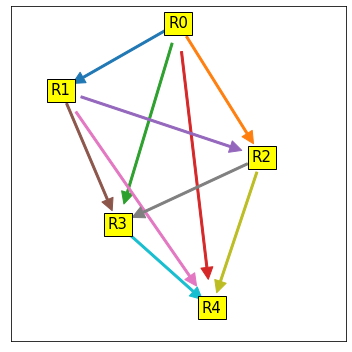

In [54]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='5sp_randChem1.dat'
analysis_file_name = 'analysis_'+sim_file_name
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)
plot_rxn_nwk_color_key(analysis_df)

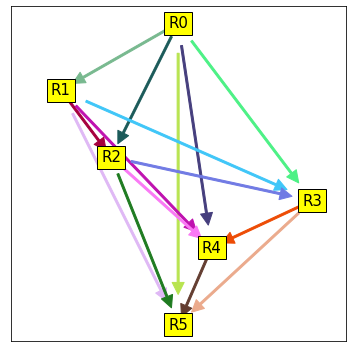

In [55]:
## with the manually specified colors..
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_heatdissipation_randChems2.dat'
analysis_file_name = 'analysis_'+sim_file_name
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)
plot_rxn_nwk_color_key(analysis_df)

## reaction network for illustrator

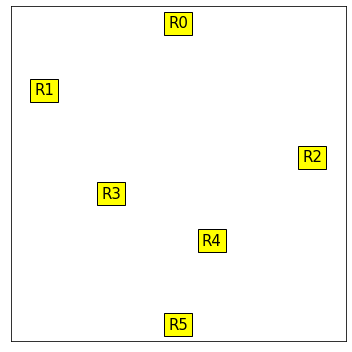

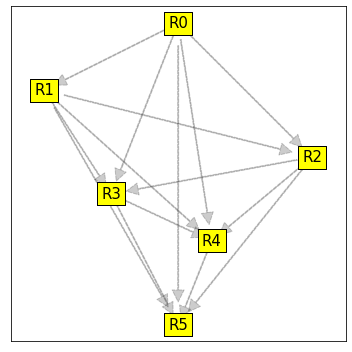

In [197]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_heatdissipation_randChems2.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id='0'
fig_folder=dest_folder+'/Fig_illustrate_max_dissipation/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)
n_resources=analysis_df['n_resources']
n_reactions=analysis_df['n_reactions']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
exp_conditions_list = analysis_df['exp_conditions_list']
resources_dict =get_resource_nwk_positions(n_resources) 
fig= plt.figure(figsize=(5,5))
ax1=fig.add_subplot()
for key,val in resources_dict.items(): 
        ax1.text(val[0],val[1],'R'+str(key), color='black',
                                 bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')

ax1.set_xticks([])  
ax1.set_yticks([]) 
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(fig_folder+'no_arrows.pdf')

fig= plt.figure(figsize=(5,5))
ax1=fig.add_subplot()

for reaction in range(n_reactions):                 
    h,w=0.15,0.15
    x,y=(np.array(resources_dict[products[reaction]])+         
         np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2    

    ax1.annotate('',xy=(resources_dict[products[reaction]]),
                    xytext=(resources_dict[substrates[reaction]]),
                    arrowprops=dict(facecolor='black', shrink=0.075,
                                             linestyle='dashed',width=1,alpha=.2)
                )
    for key,val in resources_dict.items(): 
        ax1.text(val[0],val[1],'R'+str(key), color='black',
                                 bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')

ax1.set_xticks([])  
ax1.set_yticks([]) 
plt.tight_layout()
plt.savefig(fig_folder+'with_arrows.pdf')
plt.show()


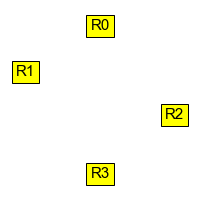

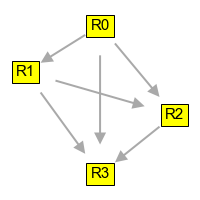

In [16]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='4sp_randChem1.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id='0'
fig_folder=dest_folder+'/Fig1_cartoon/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)
n_resources=analysis_df['n_resources']
n_reactions=analysis_df['n_reactions']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
exp_conditions_list = analysis_df['exp_conditions_list']
resources_dict =get_resource_nwk_positions(n_resources) 
resources_dict =get_resource_nwk_positions(n_resources) 
fig= plt.figure(figsize=(3,3))
ax1=fig.add_subplot()
for key,val in resources_dict.items(): 
#         ax1.text(val[0],val[1],r'R$_{%s}$'%(str(key)), color='black',
#                                  bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')
        ax1.text(val[0],val[1],'R'+str(key), color='black',
                                 bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')


#          ax1.text(val[0],val[1],r'R'+str(key), color='black',
#                                  bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')
ax1.set_xticks([])  
ax1.set_yticks([])
ax1.axis('off')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(fig_folder+'4sp_no_arrows.pdf')


fig= plt.figure(figsize=(3,3))
ax1=fig.add_subplot()
for key,val in resources_dict.items(): 
#         ax1.text(val[0],val[1],r'R$_{%s}$'%(str(key)), color='black',
#                                  bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')
        ax1.text(val[0],val[1],'R'+str(key), color='black',
                                 bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')
        
for reaction in range(n_reactions):                 
    h,w=0.15,0.15
    x,y=(np.array(resources_dict[products[reaction]])+         
         np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2    

    ax1.annotate('',xy=(resources_dict[products[reaction]]),
                    xytext=(resources_dict[substrates[reaction]]),
                    arrowprops=dict(facecolor='darkgray',edgecolor='None', shrink=0.2,
                                             width=2)
                )
ax1.set_xticks([])  
ax1.set_yticks([]) 
ax1.axis('off')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(fig_folder+'4sp_with_arrows.pdf')

In [213]:
n_resources

6

In [212]:
n_resources

6

# Figure 2 functional convergence

In [17]:
def get_max_dissipative_rxn_paths_old(df_master):
    substrates_rxn=df_master['pool0']['expt0']['params']['substrates']
    products_rxn=df_master['pool0']['expt0']['params']['products']
    Energies=df_master['pool0']['expt0']['params']['Energies']
    DG_list=df_master['pool0']['expt0']['params']['DG']
    assert all(Energies[i] >= Energies[i+1] for i in range(len(Energies)-1)), 'energies are in decreasing order'
    n_reactions=len(substrates_rxn)
    product_arr=np.array(list(set(products_rxn)))
    n_res=np.max(product_arr)+1

    product_arr=(np.arange(n_res-1)+1).astype(int)
    def get_rxn_idx(sub, prod, substrates_rxn, products_rxn):
        a= np.where(substrates_rxn==sub)[0]
        b= np.where(products_rxn==prod)[0]
        return int(np.intersect1d(a,b))
    min_DG_list=[] ## with the min DG of the different paths
    min_DG_path_list=[] ## with the reaction ids of the min DG paths
    for i, final_product in enumerate(product_arr):
        rxn_idx=get_rxn_idx(0, final_product, substrates_rxn, products_rxn)
        min_DG=DG_list[rxn_idx]
        min_DG_path=[rxn_idx]
        for j, intermediate in enumerate(product_arr[:i]):
            rxn_idx=get_rxn_idx(intermediate, final_product, substrates_rxn, products_rxn)

            DG=DG_list[rxn_idx]+min_DG_list[j]
            if DG<min_DG:
#                 print (intermediate,final_product)
#                 print (DG,min_DG)
                min_DG_path=min_DG_path_list[j] +[rxn_idx]
                min_DG=DG
#                 print (min_DG_path)
        min_DG_list.append(min_DG) ## with the min DG of the different paths
        min_DG_path_list.append(min_DG_path)    
    return min_DG_path_list, min_DG_list

def calculate_Rss_and_fluxes_theory_old(min_DG_path_list, min_DG_list, df_master,
                                    n_resources=6,Prediction_Order=1):
    
    h0=df_master['pool0']['expt0']['params']['Rsupply'][0] ##supply of R0
    substrates_rxn=df_master['pool0']['expt0']['params']['substrates']
    products_rxn=df_master['pool0']['expt0']['params']['products']
    delta=df_master['pool0']['expt0']['params']['m'] ## dilution rate
    n_reactions=len(substrates_rxn)
    
    ### we calculate theory based on pool 0 values...
    surv_idx=np.where(df_master['pool0']['expt0']['SS_values'][0]>0)[0]
    ## when we tried to say overall E budget is assigned to each reaction.
#     mean_E_budget=np.mean(np.sum(df_master['pool0']['expt0']['params']['Enzyme_alloc'][surv_idx],axis=1))
#     nu=np.mean(df_master['pool0']['expt0']['params']['Kcat'])*mean_E_budget
    E_in_each_rxn=np.sum(sim_data_df['pool0']['expt0']['params']['Enzyme_alloc'][surv_idx],axis=0)
    nu=np.mean(df_master['pool0']['expt0']['params']['Kcat'])*E_in_each_rxn
    Y_rxn=df_master['pool0']['expt0']['params']['Energy_yield']*df_master['pool0']['expt0']['params']['yield']
    delta=df_master['pool0']['expt0']['params']['m']    
    
    
    a_i_rxn=1.- delta/(nu*Y_rxn)
    a_i_rxn[nu==0]=1e-4
    a_i_over_gamma_i=np.zeros(n_resources-1)
    
    for i in range(1,n_resources): ## path to resource i
        a_i=np.prod(a_i_rxn[min_DG_path_list[i-1]])
        a_i_over_gamma_i[i-1]=a_i* np.exp(-min_DG_list[i-1])
#     print ('relative difference=',1-a_i_over_gamma_i/One_over_gamma)
    R_ss=np.zeros(n_resources)
    R_ss_0thOrder=np.zeros(n_resources)
    R_ss[0]= h0/(1+np.sum(a_i_over_gamma_i))
    R_ss_0thOrder[0]=h0/(1+np.sum(np.exp(-np.asarray(min_DG_list))))
#     R_ss[0]= h0/(1+np.sum(np.exp(-np.asarray(min_DG_list))))
    for i in range(1,n_resources):
        R_ss[i]=R_ss[0]* a_i_over_gamma_i[i-1]
        R_ss_0thOrder[i]=R_ss_0thOrder[0]* np.exp(-min_DG_list[i-1])
    #     print('relative difference Rss=',1-R_ss/R_ss_0thOrder)
    if Prediction_Order==0: ## we want to use the 0th order prediction
        R_ss=R_ss_0thOrder

    all_rxns_in_min_DG_path= list(np.concatenate(min_DG_path_list).flat)## flatten all paths
    unq_rxns_in_min_DG_path=np.array(list(set(all_rxns_in_min_DG_path))).astype(int)   
    subs_on_paths=substrates_rxn[unq_rxns_in_min_DG_path]
    prods_on_paths=products_rxn[unq_rxns_in_min_DG_path]
    
    Flux_in_rxns=np.zeros(n_reactions)
    Flux_into_resource=np.zeros(n_resources)
    '''
    loop from bottom resource to top resoruce so that we can use 
    the flux calculated downstream for current flux calculation
    '''
    for i in range (n_resources-1,0,-1): 
        flux_into_i=delta*R_ss[i]       
        if np.any(subs_on_paths==i) : ##outflow must be added for flux balance
            rxn_pathIDs=np.where(subs_on_paths==i)[0]          
            prods=prods_on_paths[rxn_pathIDs]
            print (prods, 'shared substrate', i )
            if np.any(prods<i):
                print (i,'error, prods have to be lesser', prods)
            flux_into_i=flux_into_i+np.sum(Flux_into_resource[prods])  

        if np.any(prods_on_paths==i) :
            rxn_pathID=np.where(prods_on_paths==i)[0]
            assert(len(rxn_pathID)==1),'only one inflow reaction allowed'
            Flux_in_rxns[unq_rxns_in_min_DG_path[rxn_pathID]]=flux_into_i          
        else:
            print (i, 'was not a product in any reaction???')           
        Flux_into_resource[i]=flux_into_i     
    return R_ss,  Flux_in_rxns, Flux_into_resource

#### params

In [2]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_heatdissipation_randChems2.dat'
analysis_file_name = 'analysis_'+sim_file_name
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)
    


In [4]:
sim_data_df['pool0']['expt0']['params']

{'m': 0.01,
 'reaction_network_type': 'all',
 'Energies': array([5., 4., 3., 2., 1., 0.]),
 'K_P': array([0.98801214, 0.9897506 , 1.01373065, 1.00955823, 0.99832537,
        0.98089513, 1.02144462, 0.99684557, 1.02218013, 1.00555011,
        1.00313589, 1.01261505, 1.00714465, 1.0080455 , 1.00032535]),
 'K_S': array([1.00619874, 1.02203567, 1.01048577, 0.9850014 , 0.98346262,
        0.98494736, 1.02206747, 1.02272311, 0.99121312, 0.98888627,
        0.98746739, 1.00224794, 1.00265364, 1.00928918, 1.00557001]),
 'Kcat': array([0.90517608, 0.94087995, 0.86744949, 0.87399055, 0.91453105,
        0.96683657, 0.8576704 , 1.04405012, 0.86533727, 0.975299  ,
        1.01375995, 1.11206286, 0.82928612, 0.93617408, 0.91927716]),
 'assumptions': {'nu_constraint': 'uniform_lognormal',
  'growth_type': 'thermodynamic_inhibition',
  'ATP_allocation': 'fATP_list',
  'fATP_list': array([0.04085642, 0.56559231, 0.93661047, 0.85492683, 0.61407266,
         0.6199666 , 0.6135047 , 0.05270057, 0.3117099

## Reaction network panel

### flux circles with piechart

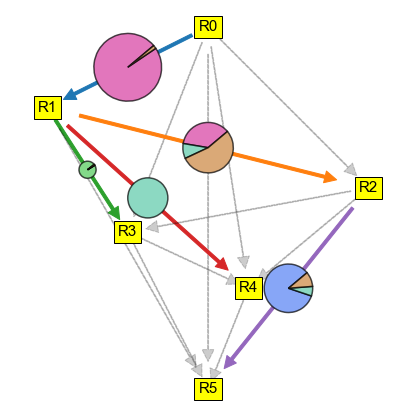

In [23]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_heatdissipation_randChems2.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id='0'
fig_folder=dest_folder+'/Fig_functional_convergence/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
    

with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

n_pools=sim_data_df['number_of_pools']
exp_conditions_list = analysis_df['exp_conditions_list']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']

expt_df = analysis_df['expt'+str(expt_id)]
pool_id=1

reactions_in_survivors = np.array(expt_df['reactions_in_final_survivors_list'][pool_id])
fluxes_by_survivors_arr = np.array(expt_df['fluxes_by_survivors_list'][pool_id])
fluxes_in_community0=np.array(expt_df['flux_in_community_list'])[pool_id]
area_scale_factor=.4
h,w=0.15,0.15


fig= plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
resources_dict =get_resource_nwk_positions(n_resources)     
color_list=get_color_list(n_resources,rxn_idxs=np.where(fluxes_in_community0>0)[0])
taxa_colors=np.array(get_taxa_colors())
for reaction in range(n_reactions): 
    if fluxes_in_community0[reaction]>0.0: 
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(color=color_list[reaction], shrink=0.1,width=3))       
        x,y=(np.array(resources_dict[products[reaction]])+         
                     np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2 
        idx_sp=np.nonzero(reactions_in_survivors[:,reaction])[0]## species that have the reaction
        weights=np.squeeze(fluxes_by_survivors_arr[idx_sp,reaction])
        pie_radius=np.sqrt(np.sum(weights)/area_scale_factor)  
        if np.sum(weights)>1e-2:
            ax_inset=ax1.inset_axes([x,y, h,w])
            weighted_fracs=np.squeeze(weights/np.sum(weights))
            if len(idx_sp)==1:
                weighted_fracs=np.array(weighted_fracs).reshape(1)
#             ax_inset.pie(weighted_fracs, autopct='%1.f%%',pctdistance=.6,
#                          colors=taxa_colors[n_pools*idx_sp+pool_id],
#                     radius=pie_radius, startangle=40,wedgeprops = {"alpha": taxa_alpha},
#                         textprops={"fontsize":10})
            ax_inset.pie([1.],
                     colors='white',radius=pie_radius)
            ax_inset.pie(weighted_fracs,
                         colors=taxa_colors[n_pools*idx_sp+pool_id],
                    radius=pie_radius, startangle=40,wedgeprops = {"alpha": taxa_alpha,
                                        'linewidth': 1.5,'edgecolor':'k'},
                        )
    else:
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(facecolor='black', shrink=0.075,
                                             linestyle='dashed',width=1,alpha=.2))
        
for key,val in resources_dict.items():                 
    ax1.text(val[0],val[1],'R'+str(key), color='black',
             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center') 
ax1.set_xticks([])  
ax1.set_yticks([])  
ax1.axis('off')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(fig_folder+'rxn_nwk_fluxes_and_taxa'+str(pool_id)+'.pdf')
# plt.savefig(fig_folder+'rxn_nwk_fluxes_and_taxa'+str(pool_id)+'.png')

plt.show()

### with piecharts and thick arrows

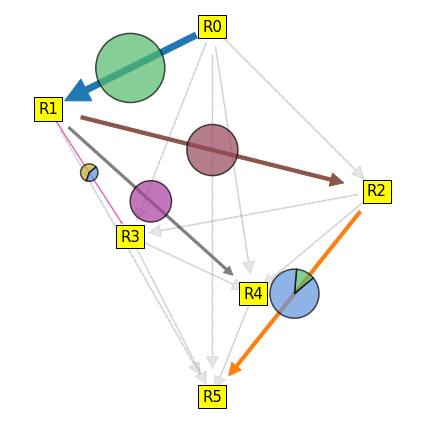

In [8]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_heatdissipation_randChems2.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id='0'
fig_folder=dest_folder+'/Fig_functional_convergence/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
    

with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

n_pools=sim_data_df['number_of_pools']
exp_conditions_list = analysis_df['exp_conditions_list']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']

expt_df = analysis_df['expt'+str(expt_id)]
pool_id=0

reactions_in_survivors = np.array(expt_df['reactions_in_final_survivors_list'][pool_id])
fluxes_by_survivors_arr = np.array(expt_df['fluxes_by_survivors_list'][pool_id])
fluxes_in_community=np.array(expt_df['flux_in_community_list'])[pool_id]
area_scale_factor=.4
h,w=0.15,0.15


fig= plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
resources_dict =get_resource_nwk_positions(n_resources)     
color_list=get_color_list(n_resources,rxn_idxs=np.where(fluxes_in_community>0)[0])
taxa_colors=np.array(get_taxa_colors())
tot_flux=np.sum(fluxes_in_community)
for reaction in range(n_reactions): 
    if fluxes_in_community[reaction]>0.0: 
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(color=color_list[reaction], shrink=0.1,
                                width=fluxes_in_community[reaction]*15./tot_flux,
                                headwidth=fluxes_in_community[reaction]*60./tot_flux,
                                headlength=fluxes_in_community[reaction]*60./tot_flux ))       
        x,y=(np.array(resources_dict[products[reaction]])+         
                     np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2 
        idx_sp=np.nonzero(reactions_in_survivors[:,reaction])[0]## species that have the reaction
        weights=np.squeeze(fluxes_by_survivors_arr[idx_sp,reaction])
        pie_radius=np.sqrt(np.sum(weights)/area_scale_factor)  
        if np.sum(weights)>1e-2:
            ax_inset=ax1.inset_axes([x,y, h,w])
            weighted_fracs=np.squeeze(weights/np.sum(weights))
            if len(idx_sp)==1:
                weighted_fracs=np.array(weighted_fracs).reshape(1)
#             ax_inset.pie(weighted_fracs, autopct='%1.f%%',pctdistance=.6,
#                          colors=taxa_colors[n_pools*idx_sp+pool_id],
#                     radius=pie_radius, startangle=40,wedgeprops = {"alpha": taxa_alpha},
#                         textprops={"fontsize":10})
            
            ax_inset.pie(weighted_fracs,
                         colors=taxa_colors[n_pools*idx_sp+pool_id],
                    radius=pie_radius, startangle=40,wedgeprops = {"alpha": taxa_alpha,
                                        'linewidth': 1.5,'edgecolor':'k'},
                        )
    else:
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(facecolor='black', shrink=0.075,
                                             linestyle='dashed',width=1,alpha=.1))
        
for key,val in resources_dict.items():                 
    ax1.text(val[0],val[1],'R'+str(key), color='black',
             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center') 
ax1.set_xticks([])  
ax1.set_yticks([])  
ax1.axis('off')
fig.patch.set_facecolor('white')
plt.tight_layout()
# plt.savefig(fig_folder+'rxn_nwk_fluxes_and_taxa'+str(pool_id)+'.pdf')
# plt.savefig(fig_folder+'rxn_nwk_fluxes_and_taxa'+str(pool_id)+'.png')

plt.show()

### donut charts

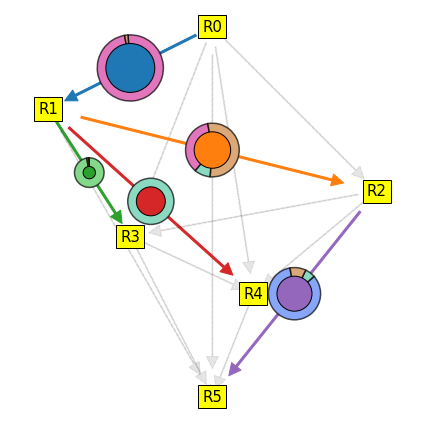

In [8]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_heatdissipation_randChems2.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id='0'
fig_folder=dest_folder+'/Fig_functional_convergence/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
    

with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

n_pools=sim_data_df['number_of_pools']
exp_conditions_list = analysis_df['exp_conditions_list']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']

expt_df = analysis_df['expt'+str(expt_id)]
pool_id=1

reactions_in_survivors = np.array(expt_df['reactions_in_final_survivors_list'][pool_id])
fluxes_by_survivors_arr = np.array(expt_df['fluxes_by_survivors_list'][pool_id])
fluxes_in_community0=np.array(expt_df['flux_in_community_list'])[pool_id]
area_scale_factor=.8
h,w=0.15,0.15


fig= plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
resources_dict =get_resource_nwk_positions(n_resources)     
color_list=get_color_list(n_resources,rxn_idxs=np.where(fluxes_in_community0>0)[0])
taxa_colors=np.array(get_taxa_colors())
for reaction in range(n_reactions): 
    if fluxes_in_community0[reaction]>0.0: 
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(color=color_list[reaction], shrink=0.1,width=2))       
        x,y=(np.array(resources_dict[products[reaction]])+         
                     np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2 
        idx_sp=np.nonzero(reactions_in_survivors[:,reaction])[0]## species that have the reaction
        weights=np.squeeze(fluxes_by_survivors_arr[idx_sp,reaction])
        pie_radius=np.sqrt(np.sum(weights)/area_scale_factor)  
        donut_radius=pie_radius+.35
        if np.sum(weights)>1e-2:
            ax_inset=ax1.inset_axes([x,y, h,w])
            weighted_fracs=np.squeeze(weights/np.sum(weights))
            if len(idx_sp)==1:
                weighted_fracs=np.array(weighted_fracs).reshape(1)
            
            #### first circle with white background to not see arrows through 
            ###the transparent part of the donut
            ax_inset.pie([1.],
                         colors='white',radius=donut_radius)
            
            ax_inset.pie(weighted_fracs,
                         colors=taxa_colors[n_pools*idx_sp+pool_id],
                    radius=donut_radius, startangle=100,wedgeprops = {"alpha": taxa_alpha,
                                        'linewidth': 1.5,'edgecolor':'k'})
            
            ax_inset.pie([1.],
                         colors=color_list[reaction:],
                    radius=pie_radius,wedgeprops = {'linewidth': 1,'edgecolor':'k'})
        
        
    else:
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(facecolor='black', shrink=0.075,
                                             linestyle='dashed',width=1,alpha=.1))
        
for key,val in resources_dict.items():                 
    ax1.text(val[0],val[1],'R'+str(key), color='black',
             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center') 
ax1.set_xticks([])  
ax1.set_yticks([])  
ax1.axis('off')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(fig_folder+'rxn_nwk_fluxes_and_taxa_donut'+str(pool_id)+'.pdf')
plt.savefig(fig_folder+'rxn_nwk_fluxes_and_taxa_donut'+str(pool_id)+'.png')

plt.show()

### without donut for talks

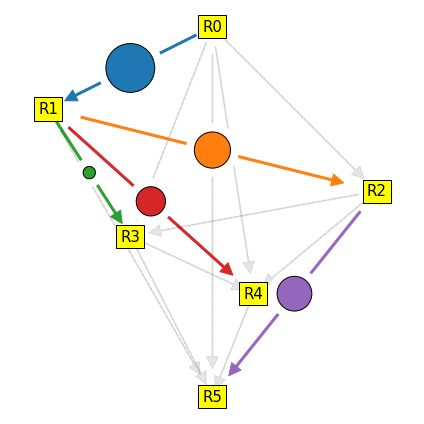

In [10]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_heatdissipation_randChems2.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id='0'
fig_folder=dest_folder+'/Fig_functional_convergence/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
    

with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

n_pools=sim_data_df['number_of_pools']
exp_conditions_list = analysis_df['exp_conditions_list']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']

expt_df = analysis_df['expt'+str(expt_id)]
pool_id=0

reactions_in_survivors = np.array(expt_df['reactions_in_final_survivors_list'][pool_id])
fluxes_by_survivors_arr = np.array(expt_df['fluxes_by_survivors_list'][pool_id])
fluxes_in_community0=np.array(expt_df['flux_in_community_list'])[pool_id]
area_scale_factor=.8
h,w=0.15,0.15


fig= plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
resources_dict =get_resource_nwk_positions(n_resources)     
color_list=get_color_list(n_resources,rxn_idxs=np.where(fluxes_in_community0>0)[0])
taxa_colors=np.array(get_taxa_colors())
for reaction in range(n_reactions): 
    if fluxes_in_community0[reaction]>0.0: 
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(color=color_list[reaction], shrink=0.1,width=2))       
        x,y=(np.array(resources_dict[products[reaction]])+         
                     np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2 
        idx_sp=np.nonzero(reactions_in_survivors[:,reaction])[0]## species that have the reaction
        weights=np.squeeze(fluxes_by_survivors_arr[idx_sp,reaction])
        pie_radius=np.sqrt(np.sum(weights)/area_scale_factor)  
        donut_radius=pie_radius+.35
        if np.sum(weights)>1e-2:
            ax_inset=ax1.inset_axes([x,y, h,w])
            weighted_fracs=np.squeeze(weights/np.sum(weights))
            if len(idx_sp)==1:
                weighted_fracs=np.array(weighted_fracs).reshape(1)
            
            #### first circle with white background to not see arrows through 
            ###the transparent part of the donut
            ax_inset.pie([1.],
                         colors='white',radius=donut_radius)
            
#             ax_inset.pie(weighted_fracs,
#                          colors=taxa_colors[n_pools*idx_sp+pool_id],
#                     radius=donut_radius, startangle=100,wedgeprops = {"alpha": taxa_alpha,
#                                         'linewidth': 1.5,'edgecolor':'k'})
            
            ax_inset.pie([1.],
                         colors=color_list[reaction:],
                    radius=pie_radius,wedgeprops = {'linewidth': 1,'edgecolor':'k'})
        
        
    else:
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(facecolor='black', shrink=0.075,
                                             linestyle='dashed',width=1,alpha=.1))
        
for key,val in resources_dict.items():                 
    ax1.text(val[0],val[1],'R'+str(key), color='black',
             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center') 
ax1.set_xticks([])  
ax1.set_yticks([])  
ax1.axis('off')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(fig_folder+'rxn_nwk_fluxes_and_taxa_NOdonut'+str(pool_id)+'_talk.pdf')
plt.savefig(fig_folder+'rxn_nwk_fluxes_and_taxa_NOdonut'+str(pool_id)+'_talk.png')

plt.show()

### only flux arrows

#### equally sized arrows for talk, (grey and colored)

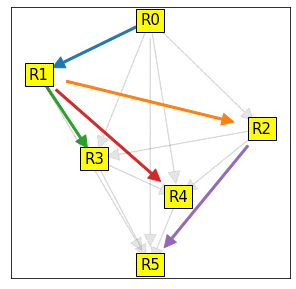

In [10]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_heatdissipation_randChems2.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id='0'
fig_folder=dest_folder+'/Fig_functional_convergence/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
    

with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

n_pools=sim_data_df['number_of_pools']
exp_conditions_list = analysis_df['exp_conditions_list']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']

expt_df = analysis_df['expt'+str(expt_id)]
fluxes_in_community0=np.array(expt_df['flux_in_community_list'])[0]



fig= plt.figure(figsize=(5,5))
ax1 = fig.add_subplot()
resources_dict =get_resource_nwk_positions(n_resources)     
color_list=get_color_list(n_resources,rxn_idxs=np.where(fluxes_in_community0>0)[0])
for reaction in range(n_reactions): 
    if fluxes_in_community0[reaction]>0.0:
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(color=color_list[reaction], shrink=0.125,
                             width=2))   ## was 2 when constant width    
    else:
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(facecolor='black', shrink=0.075,
                                             linestyle='dashed',width=.5,
                                             alpha=.1)) ##alpha=.2 for grey arrows only figure
        
        
for key,val in resources_dict.items():                 
    ax1.text(val[0],val[1],'R'+str(key), color='black',
             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')

  
ax1.set_xticks([])  
ax1.set_yticks([])  

plt.savefig(fig_folder+'rxn_nwk_colored_arrows_talk.pdf')
plt.savefig(fig_folder+'rxn_nwk_colored_arrows_talk.png')
plt.show()

#### differently sized arrows

In [ ]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_heatdissipation_randChems2.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id='0'
fig_folder=dest_folder+'/Fig_functional_convergence/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
    

with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

n_pools=sim_data_df['number_of_pools']
exp_conditions_list = analysis_df['exp_conditions_list']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']

expt_df = analysis_df['expt'+str(expt_id)]
fluxes_in_community0=np.array(expt_df['flux_in_community_list'])[0]



fig= plt.figure(figsize=(5,5))
ax1 = fig.add_subplot()
resources_dict =get_resource_nwk_positions(n_resources)     
color_list=get_color_list(n_resources,rxn_idxs=np.where(fluxes_in_community0>0)[0])
for reaction in range(n_reactions): 
    if fluxes_in_community0[reaction]>0.0:
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(color=color_list[reaction], shrink=0.125,
                             width=10*fluxes_in_community0[reaction]))   ## was 2 when constant width    
    else:
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(facecolor='black', shrink=0.075,
                                             linestyle='dashed',width=.5,alpha=.1))
        
        
for key,val in resources_dict.items():                 
    ax1.text(val[0],val[1],'R'+str(key), color='black',
             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')

  
ax1.set_xticks([])  
ax1.set_yticks([])  

plt.savefig(fig_folder+'rxn_nwk_fluxes.pdf')
plt.savefig(fig_folder+'rxn_nwk_fluxes.png')
plt.show()

array(['#a5bb36', '#789635', '#de592d'], dtype='<U7')

In [144]:
reactions_in_survivors

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.]])

In [ ]:
def plot_rxn_nwk_Fluxes_piechart_nspecies(analysis_df, plot_for_R_Expt=None,
                                          pool_ids=np.arange(10).astype(int),
                                          area_scale_factor=100.,
                                         ):
    n_resources=analysis_df['n_resources']
    n_reactions=analysis_df['n_reactions']
    substrates=analysis_df['reaction_substrates']
    products=analysis_df['reaction_products']
    exp_conditions_list = analysis_df['exp_conditions_list']
#     plot_pairs={'key':'growth_type','val1':'thermodynamic_inhibition', 'val2':'Michaelis-Menten'}
    
    n_pools=len(pool_ids)
    color_list=create_color_list(scheme_name='sns_deep')
    n_exp_conditions=len(exp_conditions_list)
    fig= plt.figure(figsize=(5*n_pools,5*n_exp_conditions))
    for pool_ctr, pool_id in enumerate(pool_ids):
        for expt_id, expt_condition in enumerate(exp_conditions_list):
            expt_df = analysis_df['expt'+str(expt_id)]
            reactions_in_final_survivors_list = expt_df['reactions_in_final_survivors_list']
            abundance_list=expt_df['abundance_of_survivors']
#             Enz_and_N_weighted_reactions_in_survivors_list=expt_df['enzyme_and_abundance_weighted_reactions_in_survivors']
            reactions_in_survivors=np.array(reactions_in_final_survivors_list[pool_id]  )
            abundance_survivors=abundance_list[pool_id]
#             Enz_and_N_weighted_reactions=np.array(Enz_and_N_weighted_reactions_in_survivors_list[pool_id])
            fluxes_by_survivors_list=expt_df['fluxes_by_survivors_list']
            fluxes_by_survivors_arr= np.array(fluxes_by_survivors_list[pool_id])
#             params_df=expt_df['sim_params']
            R_exp=expt_condition
#             ax1 = fig.add_subplot(1,n_pools,pool_ctr+1)
            ax1 = fig.add_subplot(n_exp_conditions,n_pools,
                                  expt_id*n_pools+ pool_ctr+1)
            if n_resources==4:    
                resources_dict={0:[0.5, .95],1:[0.1, .7],
                               2:[0.95, .39],
                               3:[0.23, .05]}
        
            elif n_resources==5:    
                resources_dict={0:[0.5, .92],1:[0.15, .75],
                               2:[0.75, .55],
                               3:[0.32, .35], 4:[.55,0.15]}  
                
            elif n_resources==6:
                resources_dict={0:[0.5, .97],1:[0.15, .75],
                               2:[0.3, .55],
                               3:[0.9, .42], 4:[0.6, .2],
                               5:[0.5, .02]}
            else:
                print('this nresources has not been positioned yet',n_resources)
                sys.exit(1)

            for ax in [ax1]:
                for key,val in resources_dict.items(): 
                    
                    ax.text(val[0],val[1],'R'+str(key), color='black',
                             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')
    
#                     ax.text(val[0],val[1],'R'+str(key)+' ({:.1f})'.format(
#                         params_df['Energies'][key] ) , color='black',
#                              bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center')
#                     ##draw arrows
#                     for i in range(n_reactions):   
#                         ax.annotate('',xy=(resources_dict[products[i]]),
#                                      xytext=(resources_dict[substrates[i]]),
#                                      arrowprops=dict(facecolor='black', shrink=0.075,width=1))
                ax.set_xticks([])  
                ax.set_yticks([])  
        #### add inset axis and pie chart to each reaction.
            ax_subplot=ax1


            for reaction in range(n_reactions):                 
                h,w=0.15,0.15
                x,y=(np.array(resources_dict[products[reaction]])+         
                     np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2    
                

                idx_sp=np.nonzero(reactions_in_survivors[:,reaction])## species that have the reaction
#                 if len(idx_sp)>0:
#                 print (fluxes_by_survivors_arr[idx_sp,reaction])
                weights=np.squeeze(fluxes_by_survivors_arr[idx_sp,reaction])
                pie_radius=np.sqrt(np.sum(weights)/area_scale_factor)  
            
                if np.sum(weights)>1e-2:
                    ax_inset=ax_subplot.inset_axes([x,y, h,w])
                    weighted_fracs=np.squeeze(weights/np.sum(weights))
                    if len(idx_sp[0])==1:
                        weighted_fracs=np.array(weighted_fracs).reshape(1)
    #                 print(weighted_fracs)
    #                     sp_fracs=abundance_survivors[idx_sp]/np.sum(abundance_survivors[idx_sp])
                    ax_inset.pie(weighted_fracs, autopct='%1.0f%%',
                                 colors=np.array(color_list)[idx_sp],
                            radius=pie_radius, startangle=90)
                
                    ax_subplot.annotate('',xy=(resources_dict[products[reaction]]),
                                         xytext=(resources_dict[substrates[reaction]]),
                                         arrowprops=dict(facecolor='black', shrink=0.075,width=1))
            
            w,h=0.25,0.1
            ax_inset=ax_subplot.inset_axes([0.725,0.05, w,h])
#             ax_inset.yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=3))
            rel_abundance=abundance_survivors/np.sum(abundance_survivors)
            for i in range(len(rel_abundance)):       
                ax_inset.barh(i,rel_abundance[i],label='s',color=np.array(color_list)[i], log=False)
#             ax_inset.set_xticks([1e-1, 5e-2, 1.]) 
            ax_inset.set_xticks([0.1,0.5, 1.]) 
            ax_inset.set_yticks([])   
            ax_inset.set_xlabel('relative abundance')
            n_survivors=len(reactions_in_survivors)
            ax_subplot.set_title(str(pool_id)+',h0='+
                                 '{:.1f}'.format(expt_condition[0]),
                                weight='normal')
            ax_subplot.text(0.02,.98,str(n_survivors)+' survivors', ha='left',va='top')
#             if plot_for_R_Expt is None: 
#                 if expt_condition[1]== plot_pairs['val2']:
#                     fig.patch.set_facecolor('white')
#                     plt.tight_layout()
#                     plt.show()
#     if plot_for_R_Expt is not None:
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.show()   

## Bar plot of fluxes and taxa

/Users/ashish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in true_divide


using zeroth order prediction


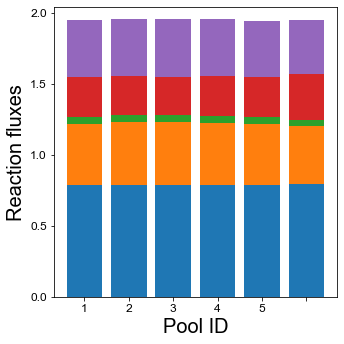

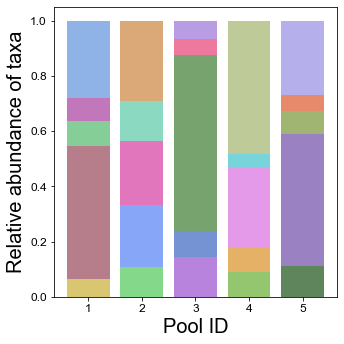

In [2]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_heatdissipation_randChems2.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id='0'
fig_folder=dest_folder+'/Fig_functional_convergence/'
if not os.path.exists(fig_folder):
    os.mkdir(fig_folder)

with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

n_pools=sim_data_df['number_of_pools']
exp_conditions_list = analysis_df['exp_conditions_list']
reaction_substrates = analysis_df['reaction_substrates']
reaction_products = analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']


fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot()
expt_df = analysis_df['expt'+str(expt_id)]
xlabels=[str(pool+1) for pool in range(n_pools)]
fluxes_in_community_arr=np.array(expt_df['flux_in_community_list'])
## get theory prediction
# min_DG_path_list,min_DG_list=get_max_dissipative_rxn_paths(sim_data_df)
min_DG_path_list, min_DG_list, DGvals_on_paths=get_max_dissipative_rxn_paths(sim_data_df)
R_ss,  Flux_in_rxns, Flux_into_resource=calculate_Rss_and_fluxes_theory(min_DG_path_list, min_DG_list, sim_data_df,
                                    n_resources=6,Prediction_Order=0)


##### add theory prediction
print('using zeroth order prediction')
fluxes_in_community_arr=np.append(fluxes_in_community_arr,[Flux_in_rxns],axis=0)
xlabels.append('')


flux_idx=np.where(fluxes_in_community_arr[0]>0)[0]
color_list=get_color_list(n_resources,rxn_idxs=flux_idx)#list(sns.color_palette(palette='deep',n_colors=n_reactions))



ax1.bar(xlabels,fluxes_in_community_arr[:,0],color=color_list[0])
bottom=fluxes_in_community_arr[:,0]
for i in range(n_reactions-1):                   
    ax1.bar(xlabels,fluxes_in_community_arr[:,i+1],
            bottom=bottom,color=color_list[i+1])
    bottom+=fluxes_in_community_arr[:,i+1]
ax1.set_xlabel('Pool ID',fontSize=BIGGER_SIZE+2,fontname='Arial')
ax1.set_ylabel('Reaction fluxes',fontSize=BIGGER_SIZE+2) 
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(0,2.04)
ax1.set_yticks([0,0.5,1.,1.5,2.])
fig.patch.set_facecolor('white')   
plt.tight_layout()
plt.savefig(fig_folder+'bar_plot_fluxes.pdf')
# plt.savefig(fig_folder+'bar_plot_fluxes.png')
# plt.savefig(fig_folder+'bar_plot_fluxes_without_theory.pdf')
# plt.savefig(fig_folder+'bar_plot_fluxes_without_theory.png')
plt.show()


######bar plot of taxa #############
survivor_abundance_list=expt_df['abundance_of_survivors']
n_species=n_resources-1 ## fixed to make an array.
survivor_abundance_arr=np.zeros((n_pools,n_species))
survivor_rel_abundance_arr=np.zeros((n_pools,n_species))
for pool in range(n_pools):
    n_survivors=len(survivor_abundance_list)
    survivor_abundance_arr[pool,:n_survivors]=survivor_abundance_list[pool]
    survivor_rel_abundance_arr[pool]= survivor_abundance_arr[pool]/np.sum(survivor_abundance_arr[pool])  
xlabels=[str(pool+1) for pool in range(n_pools)]
taxa_colors=np.array(get_taxa_colors())

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot()
ax1.bar(xlabels,survivor_rel_abundance_arr[:,0],color=taxa_colors[0:n_pools], alpha=taxa_alpha)
bottom=survivor_rel_abundance_arr[:,0]
for i in range(1,n_species):   
    ax1.bar(xlabels,survivor_rel_abundance_arr[:,i],
            bottom=bottom,color=taxa_colors[n_pools*i:n_pools*(i+1)], alpha=taxa_alpha)
    bottom+=survivor_rel_abundance_arr[:,i]
ax1.set_xlabel('Pool ID',fontSize=BIGGER_SIZE+2,fontname='Arial')#,fontname='Arial'
ax1.set_ylabel('Relative abundance of taxa',fontSize=BIGGER_SIZE+2)#, )
               
ax1.tick_params(axis='both', which='major', labelsize=12)
fig.patch.set_facecolor('white')   
plt.tight_layout()
plt.savefig(fig_folder+'bar_plot_taxa.pdf')
# plt.savefig(fig_folder+'bar_plot_taxa.png')
# plt.savefig(fig_folder+'bar_plot_taxa-helv.pdf')
# plt.savefig(fig_folder+'bar_plot_taxa-helv.png')
plt.show()


In [148]:
idx_sp

array([1, 3, 4])

#### aspect ratio for talk 

/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:269: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


using zeroth order prediction


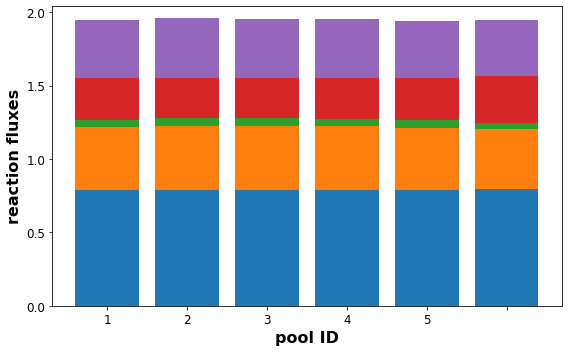

/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


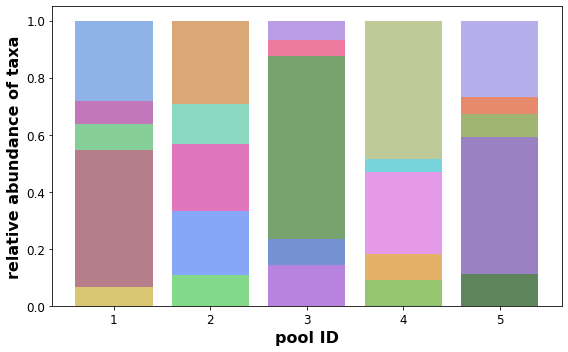

In [4]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_heatdissipation_randChems2.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id='0'
fig_folder=dest_folder+'/Fig_functional_convergence/'
if not os.path.exists(fig_folder):
    os.mkdir(fig_folder)

with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

n_pools=sim_data_df['number_of_pools']
exp_conditions_list = analysis_df['exp_conditions_list']
reaction_substrates = analysis_df['reaction_substrates']
reaction_products = analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']


fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot()
expt_df = analysis_df['expt'+str(expt_id)]
xlabels=[str(pool+1) for pool in range(n_pools)]
fluxes_in_community_arr=np.array(expt_df['flux_in_community_list'])
## get theory prediction
# min_DG_path_list,min_DG_list=get_max_dissipative_rxn_paths(sim_data_df)
min_DG_path_list, min_DG_list, DGvals_on_paths=get_max_dissipative_rxn_paths(sim_data_df)
R_ss,  Flux_in_rxns, Flux_into_resource=calculate_Rss_and_fluxes_theory(min_DG_path_list, min_DG_list, sim_data_df,
                                    n_resources=6,Prediction_Order=0)


##### add theory prediction
print('using zeroth order prediction')
fluxes_in_community_arr=np.append(fluxes_in_community_arr,[Flux_in_rxns],axis=0)
xlabels.append('')


flux_idx=np.where(fluxes_in_community_arr[0]>0)[0]
color_list=get_color_list(n_resources,rxn_idxs=flux_idx)#list(sns.color_palette(palette='deep',n_colors=n_reactions))



ax1.bar(xlabels,fluxes_in_community_arr[:,0],color=color_list[0])
bottom=fluxes_in_community_arr[:,0]
for i in range(n_reactions-1):                   
    ax1.bar(xlabels,fluxes_in_community_arr[:,i+1],
            bottom=bottom,color=color_list[i+1])
    bottom+=fluxes_in_community_arr[:,i+1]
ax1.set_xlabel('pool ID',fontSize=BIGGER_SIZE+2)
ax1.set_ylabel('reaction fluxes',fontSize=BIGGER_SIZE+2) 
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylim(0,2.04)
ax1.set_yticks([0,0.5,1.,1.5,2.])
fig.patch.set_facecolor('white')   
plt.tight_layout()
# plt.savefig(fig_folder+'bar_plot_fluxes_talk.pdf')
# plt.savefig(fig_folder+'bar_plot_fluxes_talk.png')
plt.savefig(fig_folder+'bar_plot_fluxes_with_theory_talk.pdf')
plt.savefig(fig_folder+'bar_plot_fluxes_with_theory_talk.png')
plt.show()


######bar plot of taxa #############
survivor_abundance_list=expt_df['abundance_of_survivors']
n_species=n_resources-1 ## fixed to make an array.
survivor_abundance_arr=np.zeros((n_pools,n_species))
survivor_rel_abundance_arr=np.zeros((n_pools,n_species))
for pool in range(n_pools):
    n_survivors=len(survivor_abundance_list)
    survivor_abundance_arr[pool,:n_survivors]=survivor_abundance_list[pool]
    survivor_rel_abundance_arr[pool]= survivor_abundance_arr[pool]/np.sum(survivor_abundance_arr[pool])  
xlabels=[str(pool+1) for pool in range(n_pools)]
taxa_colors=np.array(get_taxa_colors())

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot()
ax1.bar(xlabels,survivor_rel_abundance_arr[:,0],color=taxa_colors[0:n_pools], alpha=taxa_alpha)
bottom=survivor_rel_abundance_arr[:,0]
for i in range(1,n_species):   
    ax1.bar(xlabels,survivor_rel_abundance_arr[:,i],
            bottom=bottom,color=taxa_colors[n_pools*i:n_pools*(i+1)], alpha=taxa_alpha)
    bottom+=survivor_rel_abundance_arr[:,i]
ax1.set_xlabel('pool ID',fontSize=BIGGER_SIZE+2)
ax1.set_ylabel('relative abundance of taxa',fontSize=BIGGER_SIZE+2) 
ax1.tick_params(axis='both', which='major', labelsize=12)
fig.patch.set_facecolor('white')   
plt.tight_layout()
plt.savefig(fig_folder+'bar_plot_taxa_talk.pdf')
plt.savefig(fig_folder+'bar_plot_taxa_talk.png')
plt.show()


In [146]:
taxa_colors[n_pools*idx_sp]

array(['#a5bb36', '#789635', '#de592d'], dtype='<U7')

# Fig 4 vs dilution rate or steady-state growth rate

In [63]:
# data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/cluster/S6_dilution_1/'
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/cluster/S6_dilution_2/'
sim_file_name='sim_dilution.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id=5
pool_id=0
#pool_id=1
fig_folder=dest_folder+'/Fig_vs_dilution_growth_rate/'
nwk_fig_folder=fig_folder+'/Network_figs/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
if not os.path.exists(nwk_fig_folder): os.mkdir(nwk_fig_folder)
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)
    
mean_gmax=2.73
n_resources  =6
'''gmax is mean (kcat) * mean (Ealloc budget) *1 *1
(EATP=1, and Y=1 )
mean kcat is  exp(lne +.0001/2) and so approximately  1
mean Ealloc is approximately exp(1+.01/2) and so is 2.73
and so mean gmax is  2.73 '''

'gmax is mean (kcat) * mean (Ealloc budget) *1 *1\n(EATP=1, and Y=1 )\nmean kcat is  exp(lne +.0001/2) and so approximately  1\nmean Ealloc is approximately exp(1+.01/2) and so is 2.73\nand so mean gmax is  2.73 '

In [8]:
sim_data_df['pool0']['expt0']['params']

{'m': 0.00625,
 'reaction_network_type': 'all',
 'Energies': array([5., 4., 3., 2., 1., 0.]),
 'K_P': array([0.98933099, 0.98165745, 0.98889751, 0.99387579, 0.99138773,
        0.9899343 , 1.00275644, 0.9970398 , 1.01113846, 1.02041148,
        0.99950115, 1.00290553, 0.98915567, 0.98715263, 0.98483203]),
 'K_S': array([1.00415479, 1.01274982, 0.99503536, 1.00671092, 1.00252526,
        0.99270597, 1.00870379, 1.0057758 , 1.01523543, 1.00871905,
        1.01833132, 0.99999259, 1.00275547, 0.99602185, 1.00234771]),
 'Kcat': array([1.0072956 , 1.00956655, 1.00606771, 1.0145336 , 1.01804797,
        0.99234558, 1.00174218, 0.99590963, 0.9763921 , 0.98641214,
        0.99883966, 0.99442665, 0.99973206, 1.01070767, 1.00335533]),
 'assumptions': {'nu_constraint': 'uniform_lognormal',
  'growth_type': 'thermodynamic_inhibition',
  'ATP_allocation': 'fATP_list',
  'fATP_list': array([0.68730415, 0.17320986, 0.41040171, 0.19615637, 0.33648042,
         0.24646699, 0.16331297, 0.3298413 , 0.6147

## plot of fluxes in network

(array([0, 2, 3, 4, 5]),)
0
2
3
4
5


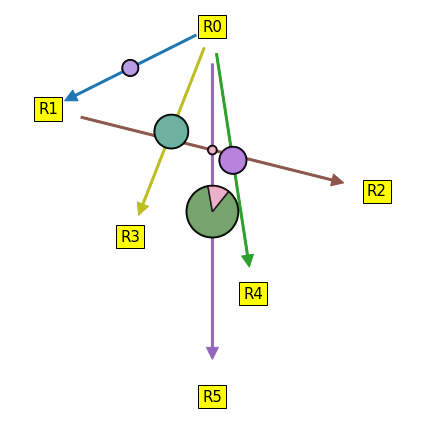

In [91]:
min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(sim_data_df)
flat_list = [item for sublist in min_DG_path_list for item in sublist]
rxns_predicted=np.unique(flat_list)

color_list=get_color_list(n_resources,rxn_idxs=rxns_predicted)
color_list[9]=color_list[6]
color_list[2]=color_list[8]
expt_id=8
pool_id=2


n_pools=sim_data_df['number_of_pools']
exp_conditions_list=analysis_df['exp_conditions_list']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']
expt_df = analysis_df['expt'+str(expt_id)]
exp_condition=exp_conditions_list[expt_id]

reactions_in_survivors = np.array(expt_df['reactions_in_final_survivors_list'][pool_id])
fluxes_by_survivors_arr = np.array(expt_df['fluxes_by_survivors_list'][pool_id])
fluxes_in_community=np.array(expt_df['flux_in_community_list'])[pool_id]
area_scale_factor=np.sum(fluxes_in_community)/2
h,w=0.15,0.15
print(np.where(fluxes_in_community>0))


fig= plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
resources_dict =get_resource_nwk_positions(n_resources)     

taxa_colors=np.array(get_taxa_colors())
for reaction in range(n_reactions): 
#     if reaction in rxns_predicted:
#         ax1.annotate('',xy=(resources_dict[products[reaction]]),
#                              xytext=(resources_dict[substrates[reaction]]),
#                              arrowprops=dict(color='grey', shrink=0.1,width=4, linestyle=':'))       
    
    if fluxes_in_community[reaction]>0.0: 
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(color=color_list[reaction], shrink=0.1,width=2))       
        x,y=(np.array(resources_dict[products[reaction]])+         
                     np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2 
        idx_sp=np.nonzero(reactions_in_survivors[:,reaction])[0]## species that have the reaction
        weights=np.squeeze(fluxes_by_survivors_arr[idx_sp,reaction])
        pie_radius=np.sqrt(np.sum(weights)/area_scale_factor)  
#         donut_radius=pie_radius+.35
        if np.sum(weights)>1e-4:
            ax_inset=ax1.inset_axes([x,y, h,w])
            weighted_fracs=np.squeeze(weights/np.sum(weights))
            if len(idx_sp)==1:
                weighted_fracs=np.array(weighted_fracs).reshape(1)
            
            #### first circle with white background to not see arrows through 
            ###the transparent part of the donut
            ax_inset.pie([1.],
                         colors='white',radius=pie_radius,wedgeprops = {
                                        'linewidth': 2,'edgecolor':'k'})          
            ax_inset.pie(weighted_fracs,
                         colors=taxa_colors[n_pools*idx_sp+pool_id],
                    radius=pie_radius, startangle=100,wedgeprops = {"alpha": taxa_alpha,
                                        'linewidth': 1.5,'edgecolor':'k'})
            
#             ax_inset.pie([1.],
#                          colors=color_list[reaction:],
#                     radius=pie_radius,wedgeprops = {'linewidth': 1,'edgecolor':'k'})
            print(reaction)
        
#     else: 
#         ax1.annotate('',xy=(resources_dict[products[reaction]]),
#                              xytext=(resources_dict[substrates[reaction]]),
#                              arrowprops=dict(facecolor='black', shrink=0.075,
#                                              linestyle='dashed',width=1,alpha=.1))
        
for key,val in resources_dict.items():                 
    ax1.text(val[0],val[1],'R'+str(key), color='black',
             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center') 
ax1.set_xticks([])  
ax1.set_yticks([])  
ax1.axis('off')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(nwk_fig_folder+'/rxn_nwk-expt_'+str(expt_id)+'delta'+str(exp_condition)+'-pool'+str(pool_id)+'.pdf')
plt.savefig(nwk_fig_folder+'/rxn_nwk-expt_'+str(expt_id)+'delta'+str(exp_condition)+'-pool'+str(pool_id)+'.png')
plt.show()

In [50]:
rxns_predicted

array([ 0,  1,  3,  9, 14])

In [48]:
color_list

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

## donut plot of relative fluxes in network 

0
1
2
3
4


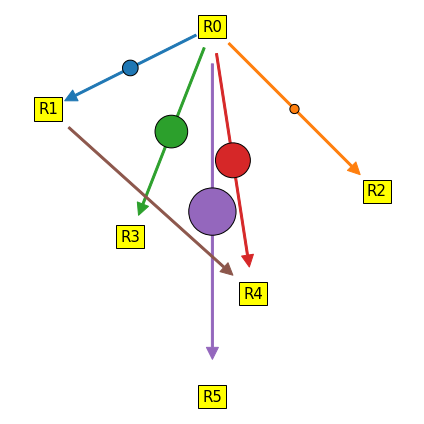

In [6]:
expt_id=7
pool_id=1


n_pools=sim_data_df['number_of_pools']
exp_conditions_list=analysis_df['exp_conditions_list']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']
expt_df = analysis_df['expt'+str(expt_id)]
exp_condition=exp_conditions_list[expt_id]

reactions_in_survivors = np.array(expt_df['reactions_in_final_survivors_list'][pool_id])
fluxes_by_survivors_arr = np.array(expt_df['fluxes_by_survivors_list'][pool_id])
fluxes_in_community=np.array(expt_df['flux_in_community_list'])[pool_id]
area_scale_factor=np.sum(fluxes_in_community)/2
h,w=0.15,0.15


fig= plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
resources_dict =get_resource_nwk_positions(n_resources)     
color_list=get_color_list(n_resources,rxn_idxs=np.where(fluxes_in_community>0)[0])
taxa_colors=np.array(get_taxa_colors())
for reaction in range(n_reactions): 
    if fluxes_in_community[reaction]>0.0: 
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(color=color_list[reaction], shrink=0.1,width=2))       
        x,y=(np.array(resources_dict[products[reaction]])+         
                     np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2 
        idx_sp=np.nonzero(reactions_in_survivors[:,reaction])[0]## species that have the reaction
        weights=np.squeeze(fluxes_by_survivors_arr[idx_sp,reaction])
        pie_radius=np.sqrt(np.sum(weights)/area_scale_factor)  
        donut_radius=pie_radius+.35
        if np.sum(weights)>1e-2:
            ax_inset=ax1.inset_axes([x,y, h,w])
            weighted_fracs=np.squeeze(weights/np.sum(weights))
            if len(idx_sp)==1:
                weighted_fracs=np.array(weighted_fracs).reshape(1)
            
            #### first circle with white background to not see arrows through 
            ###the transparent part of the donut
#             ax_inset.pie([1.],
#                          colors='white',radius=donut_radius)          
#             ax_inset.pie(weighted_fracs,
#                          colors=taxa_colors[n_pools*idx_sp+pool_id],
#                     radius=donut_radius, startangle=100,wedgeprops = {"alpha": taxa_alpha,
#                                         'linewidth': 1.5,'edgecolor':'k'})
            
            ax_inset.pie([1.],
                         colors=color_list[reaction:],
                    radius=pie_radius,wedgeprops = {'linewidth': 1,'edgecolor':'k'})
            print(reaction)
        
#     else: 
#         ax1.annotate('',xy=(resources_dict[products[reaction]]),
#                              xytext=(resources_dict[substrates[reaction]]),
#                              arrowprops=dict(facecolor='black', shrink=0.075,
#                                              linestyle='dashed',width=1,alpha=.1))
        
for key,val in resources_dict.items():                 
    ax1.text(val[0],val[1],'R'+str(key), color='black',
             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center') 
ax1.set_xticks([])  
ax1.set_yticks([])  
ax1.axis('off')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(nwk_fig_folder+'/rxn_nwk_fluxes_and_taxa_NOdonut-delta'+str(exp_condition)+'-pool'+str(pool_id)+'.pdf')
plt.savefig(nwk_fig_folder+'/rxn_nwk_fluxes_and_taxa_NOdonut-delta'+str(exp_condition)+'-pool'+str(pool_id)+'.png')

plt.show()

In [52]:
np.where(fluxes_in_community>0)

(array([1, 2, 3, 4]),)

In [41]:
np.shape(fluxes_by_survivors_arr)

(4, 15)

## plot of functional distance 

JSD is monotonic if distance to theory is plotted, distance between pools is not monotonic for JSD

/Users/ashish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


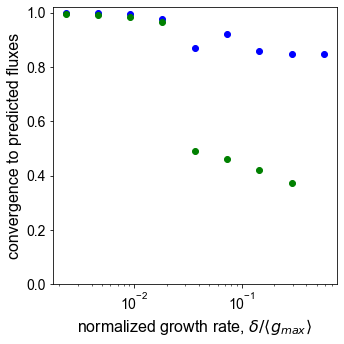

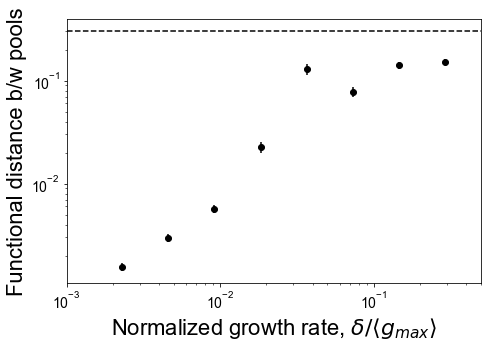

In [9]:
avg_pwise_dist=[]
avg_dist_to_theory=[]
stderrm_pwise_dist=[]
stderrm_dist_to_theory=[]
min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(sim_data_df)
for idx, val in enumerate(analysis_df['exp_conditions_list']):
    exp_label='expt'+ str(idx)        
    pwise_dists=distance.pdist(analysis_df[exp_label]['flux_in_community_list'], 
                               metric='jensenshannon')
    avg_pwise_dist.append(np.mean(pwise_dists))
    stderrm_pwise_dist.append(np.std(pwise_dists)/np.sqrt(len(pwise_dists)))
    R_ss,  Flux_in_rxns, Flux_into_resource=calculate_Rss_and_fluxes_theory(min_DG_path_list, min_DG_list, sim_data_df,
                        n_resources=n_resources,Prediction_Order=1,
                        exp_label=exp_label)     
    dist_to_theory=[]
    for pool_id in range(analysis_df['number_of_pools']):
        dist_to_theory.append(distance.jensenshannon (
            Flux_in_rxns, analysis_df[exp_label]['flux_in_community_list'][pool_id])  )          
    avg_dist_to_theory.append(np.mean(dist_to_theory))
    stderrm_dist_to_theory.append(np.std(dist_to_theory)/np.sqrt(len(dist_to_theory)))

    

delta_vals=np.array(analysis_df['exp_conditions_list'])
nmzed_growth_rate=delta_vals/mean_gmax
fig = plt.figure(figsize=(5, 5))
ax1=fig.add_subplot()
ax1.set_ylim(0.0,1.02)
ax1.set_xscale('log')
ax1.plot(nmzed_growth_rate, 1.-np.array(avg_pwise_dist), 'bo', label= 'dist b/w pools')
ax1.plot(nmzed_growth_rate,1.-np.array(avg_dist_to_theory), 'go', label= 'dist from theory')
ax1.set_xlabel(r'normalized growth rate, $\delta/ \langle g_{max} \rangle$')
ax1.set_ylabel('convergence to predicted fluxes')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(fig_folder+'functional_convergence_to_theory-delta.pdf')
plt.show() 

JSD_random_flux=0.30 ## calculated below f

fig = plt.figure(figsize=(7, 5))
ax1=fig.add_subplot()
ax1.errorbar(nmzed_growth_rate , avg_pwise_dist, yerr=stderrm_pwise_dist, fmt='ko')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_xlim(1e-3, 5e-1)
ax1.errorbar([1e-3, 5e-1 ], [JSD_random_flux,JSD_random_flux], fmt='k--')
ax1.set_xlabel(r'Normalized growth rate, $\delta/ \langle g_{max} \rangle$', fontsize=BIGGEST_SIZE)
ax1.set_ylabel('Functional distance b/w pools',fontsize=BIGGEST_SIZE)
fig.patch.set_facecolor('white')
plt.tight_layout()

plt.savefig(fig_folder+'functional_distance-delta.pdf')
plt.show() 

### JSD between random flux vectors

In [52]:
### two ways of calculating distance between random fluxes
##1) just a flux vector of size 15 with all elements chosen from a uniform distribution.
totally_random_fluxes= np.random.rand(1500).reshape((100,15))
print ('totally random flux expectation', 
       np.mean(distance.pdist(totally_random_fluxes, metric='jensenshannon'))) 

##2) A flux vector of size 15 with the constraint that in-degree is 1, i.e, 1 reaction to 1, 2 reactions to 2, etc.    
n_replicates=100
random_flux_list=[]
for ridx in range(n_replicates):
    a=np.zeros(15)
    ctr=0
    for i in range (1,6):
        a[ctr:ctr+i]=np.random.rand(i)
    #     a[np.random.choice(np.arange(ctr,ctr+i,dtyp=int))]
        nonzero_rxn=np.random.randint(ctr,high=ctr+i)
        a[nonzero_rxn]=np.random.rand()
#         print (nonzero_rxn,ctr,ctr+i)
        ctr=ctr+i
    random_flux_list.append(a)
    
        
print ('constrained random flux expectation', 
       np.mean(distance.pdist(random_flux_list, metric='jensenshannon')) )

totally random flux expectation 0.3061963588828191
constrained random flux expectation 0.30331109238337134


In [50]:
b=np.nonzero(analysis_df['expt0']['flux_in_community_list'][0])[0]

In [48]:
np.intersect1d(a,b)

array([], dtype=float64)

## fraction of reactions predicted by max dissipation

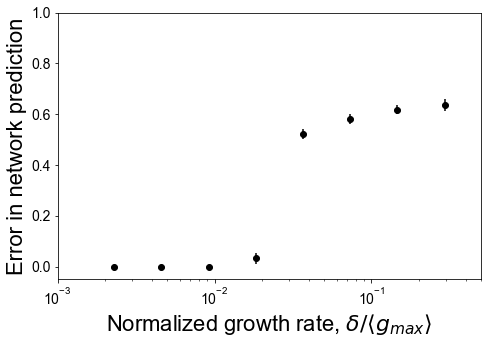

In [64]:
max_dissip_accuracy=[]
max_dissip_accuracy_stderrm=[]
min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(sim_data_df)
flat_list = [item for sublist in min_DG_path_list for item in sublist]
rxns_predicted=np.unique(flat_list)
for idx, val in enumerate(analysis_df['exp_conditions_list']):
    exp_label='expt'+ str(idx)    
    nwk_similarity=[]
    for pool_id in range(analysis_df['number_of_pools']):
        flux_in_community=analysis_df[exp_label]['flux_in_community_list'][pool_id]
        rxns_realized=np.nonzero(flux_in_community)[0]
        n_rxns_correct=len(np.intersect1d(rxns_realized,rxns_predicted)) ##A intersect B
        n_tot_rxns=len(rxns_realized)+ len(rxns_predicted)-n_rxns_correct ## A union B
        nwk_similarity.append(n_rxns_correct*1./n_tot_rxns)
        
        
    max_dissip_accuracy.append(np.mean(nwk_similarity))
    max_dissip_accuracy_stderrm.append(np.std(nwk_similarity)/np.sqrt(len(nwk_similarity)))
    

    

delta_vals=np.array(analysis_df['exp_conditions_list'])
nmzed_growth_rate=delta_vals/mean_gmax
fig = plt.figure(figsize=(7, 5))
ax1=fig.add_subplot()

ax1.set_xlim(1e-3, 5e-1)
ax1.set_xscale('log')
# ax1.plot(nmzed_growth_rate, max_dissip_accuracy, 'bo')
## for plotting accuracy
# ax1.set_ylim(0.0,1.05)
# ax1.errorbar(nmzed_growth_rate, max_dissip_accuracy, yerr= max_dissip_accuracy_stderrm,
#              fmt='ko')
# ax1.set_ylabel('accuracy of predicted network',fontsize=BIGGEST_SIZE)
### for plotting error
ax1.set_ylim(-0.05,1.0)
ax1.errorbar(nmzed_growth_rate,1-np.asarray(max_dissip_accuracy), yerr= max_dissip_accuracy_stderrm,
             fmt='ko')
ax1.set_ylabel('Error in network prediction',fontsize=BIGGEST_SIZE)


ax1.set_xlabel(r'Normalized growth rate, $\delta/ \langle g_{max} \rangle$',fontsize=BIGGEST_SIZE)

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(fig_folder+'max_dissip_accuracy-delta.pdf')
plt.show() 



# fig = plt.figure(figsize=(5, 5))
# ax1=fig.add_subplot()
# ax1.plot(nmzed_growth_rate , avg_pwise_dist, 'bo', label= 'dist b/w pools')
# # ax1.plot(nmzed_growth_rate,avg_dist_to_theory[:-1], 'go', label= 'dist from theory')
# ax1.set_yscale('log')
# ax1.set_xscale('log')
# ax1.set_xlabel(r'normalized growth rate, $\delta/ \langle g_{max} \rangle$')
# ax1.set_xlim(1e-3, 5e-1)
# ax1.set_ylabel('functional distance between realizations')
# fig.patch.set_facecolor('white')
# plt.tight_layout()

# plt.savefig(fig_folder+'functional_distance-delta.pdf')
# plt.show() 

## total flux vs growth rate

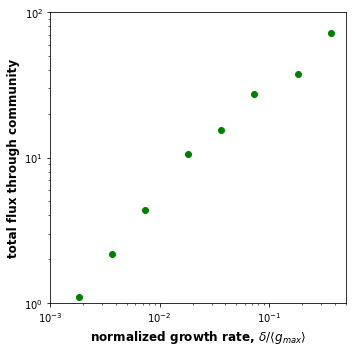

In [36]:
total_flux_list=[]


for idx, val in enumerate(analysis_df['exp_conditions_list']):
    exp_label='expt'+ str(idx)        

    fluxes=[]
    for pool_id in range(analysis_df['number_of_pools']):  
        fluxes.append(np.sum(analysis_df[exp_label]['flux_in_community_list'][pool_id]))
#         print (np.sum(analysis_df[exp_label]['flux_in_community_list'][pool_id]))
    total_flux_list.append(np.mean(fluxes))

delta_vals=np.array(analysis_df['exp_conditions_list'])
nmzed_growth_rate=delta_vals/mean_gmax
fig = plt.figure(figsize=(5, 5))
ax1=fig.add_subplot()
# ax1.set_ylim(0.0,1.02)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(nmzed_growth_rate, total_flux_list, 'go')
ax1.set_xlabel(r'normalized growth rate, $\delta/ \langle g_{max} \rangle$')
ax1.set_ylabel('total flux through community')
ax1.set_ylim(1,100)
ax1.set_xlim(1e-3,5e-1)

fig.patch.set_facecolor('white')
plt.tight_layout()

plt.savefig(fig_folder+'totalflux-delta.pdf')
plt.show() 



## PCA plot

make  a data frame that has index being expt_label+pool_id and each column being the flux in one of the reactions

In [37]:
flux_dict={'id':[] }
for i in range(analysis_df['n_reactions']):
    flux_dict.update({'rxn'+str(i):[]})

for idx, val in enumerate(analysis_df['exp_conditions_list']):
    exp_label='expt'+ str(idx)        
    n_replicates=len(analysis_df[exp_label]['flux_in_community_list'])
    for j in range(n_replicates):
        flux_dict['id'].append(exp_label+'_rep'+str(j))
        flux_in_community=analysis_df[exp_label]['flux_in_community_list'][j]
        
        for i in range(analysis_df['n_reactions']):
            flux_dict['rxn'+str(i)].append(flux_in_community[i])
                             
flux_df=pd.DataFrame(flux_dict)
flux_df=flux_df.set_index('id')   

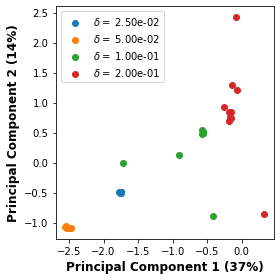

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_st =  StandardScaler().fit_transform(flux_df)
pca_out = PCA(n_components=2).fit(df_st)
pca_vals=pca_out.transform(df_st)


expt_id_list=[]
for ind in flux_df.index:
    expt_id_list.append( int(ind.split('_')[0].replace('expt','')) )

n_expts=len(analysis_df['exp_conditions_list'] )
fig= plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()

for expt_id in np.arange(2,6):
    idxs=np.where(np.array(expt_id_list)==expt_id)[0]
    ax1.scatter(pca_vals[idxs,0],pca_vals[idxs,1],
                label=r'$\delta=$ {:.2e}'.format(analysis_df['exp_conditions_list'][expt_id]   ))

    
    ax1.set_xlabel('Principal Component 1 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[0]*100))
    ax1.set_ylabel('Principal Component 2 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[1]*100))
ax1.legend(loc='best')
fig.patch.set_facecolor('white')
plt.tight_layout()
fig_folder='/Users/ashish/Dropbox/research/Sergei/simple metabolic CR model/figures/Fig_vs_dilution_growth_rate/'
plt.savefig(fig_folder+'PCA_plot_stdscaled.pdf')

plt.show()

##### unscaled PCA has PC1 which is total flux because R0 is held constant in our simulations, not R0*delta like in the expt.

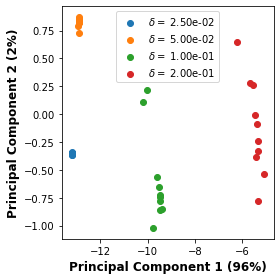

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_out = PCA(n_components=2).fit(flux_df)
pca_vals=pca_out.transform(flux_df)


expt_id_list=[]
for ind in flux_df.index:
    expt_id_list.append( int(ind.split('_')[0].replace('expt','')) )

n_expts=len(analysis_df['exp_conditions_list'] )
fig= plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()

for expt_id in np.arange(2,6):
    idxs=np.where(np.array(expt_id_list)==expt_id)[0]
    ax1.scatter(pca_vals[idxs,0],pca_vals[idxs,1],
                label=r'$\delta=$ {:.2e}'.format(analysis_df['exp_conditions_list'][expt_id]   ))

    
    ax1.set_xlabel('Principal Component 1 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[0]*100))
    ax1.set_ylabel('Principal Component 2 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[1]*100))
ax1.legend(loc='best')
fig.patch.set_facecolor('white')
plt.tight_layout()
# fig_folder='/Users/ashish/Dropbox/research/Sergei/simple metabolic CR model/figures/Fig_vs_dilution_growth_rate'
# plt.savefig(fig_folder+'PCA_plot_notscaled.pdf')

plt.show()

# plot vary dilution with fixed Flux

In [121]:
base_fold='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/cluster/'
# data_folder=base_fold+'S6_dilution_ExpStyle5/'
# exp_suffix='-expstyle5'
data_folder=base_fold+'S6_dilution_ExpStyle7/'
exp_suffix='-expstyle7'
idx_to_plot=[0,1,2,3,4,5,6] ## the expts to plot (same number as in Exp data, equally spaced)
# idx_to_plot=[1,2,3,4,5]
if exp_suffix=='-expstyle5':
    idx_to_plot=[2,3,4,5,6] ## for 5
elif exp_suffix=='-expstyle7':
    idx_to_plot=[0,1,2,3,4,5,] 
sim_file_name='sim_dilution.dat'
analysis_file_name = 'analysis_'+sim_file_name
fig_folder='/Users/ashish/Dropbox/research/Sergei/simple metabolic CR model/figures/Fig_vs_dilution_FluxConstant/'
# expt_id=5
# pool_id=0
#pool_id=1
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
# fig_folder=dest_folder+'/Fig_vs_dilution_FluxConstant/'
# nwk_fig_folder=fig_folder+'/Network_figs/'
# if not os.path.exists(nwk_fig_folder): os.mkdir(nwk_fig_folder)


with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

mean_kcat=np.mean(sim_data_df['pool0']['expt0']['params']['Kcat'])
assert math.isclose(mean_kcat, 1.01, rel_tol=1e-1) , 'mean_gmax assumes sigma_kcat is .15, will change if larger'
    
mean_gmax=2.75
n_resources  =6
'''gmax is mean (kcat) * mean (Ealloc budget) *1 *1
(EATP=1, and Y=1 )
mean kcat is  exp(0 +.0225/2) and so approximately  1.01
mean Ealloc is approximately exp(1+.01/2) and so is 2.73
and so mean gmax is  2.73*1.01=1.05 '''

'gmax is mean (kcat) * mean (Ealloc budget) *1 *1\n(EATP=1, and Y=1 )\nmean kcat is  exp(0 +.0225/2) and so approximately  1.01\nmean Ealloc is approximately exp(1+.01/2) and so is 2.73\nand so mean gmax is  2.73*1.01=1.05 '

In [9]:
np.mean(sim_data_df['pool0']['expt0']['params']['Kcat'])

1.0392150126389683

In [63]:
sim_data_df['pool0']['expt0']['params']['Energies']

array([5. , 4.2, 3.7, 2.4, 1.4, 0. ])

## JSD of fluxes

/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:269: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


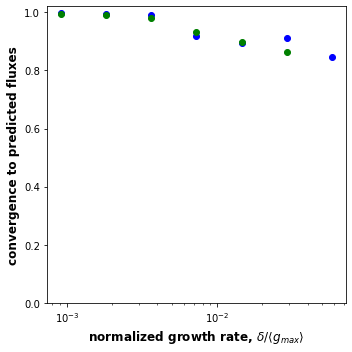

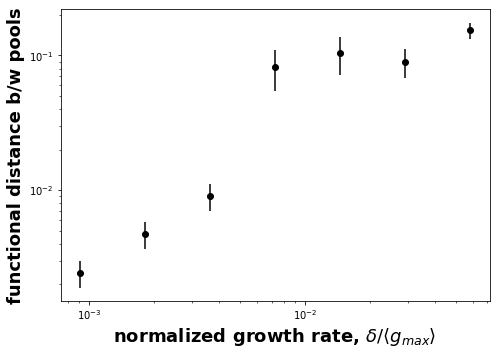

In [14]:
avg_pwise_dist=[]
avg_dist_to_theory=[]
stderrm_pwise_dist=[]
stderrm_dist_to_theory=[]
min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(sim_data_df)
for idx, val in enumerate(analysis_df['exp_conditions_list']):
    exp_label='expt'+ str(idx)        
    pwise_dists=distance.pdist(analysis_df[exp_label]['flux_in_community_list'], 
                               metric='jensenshannon')
    avg_pwise_dist.append(np.mean(pwise_dists))
    stderrm_pwise_dist.append(np.std(pwise_dists)/np.sqrt(len(pwise_dists)))
    R_ss,  Flux_in_rxns, Flux_into_resource=calculate_Rss_and_fluxes_theory(min_DG_path_list, min_DG_list, sim_data_df,
                        n_resources=n_resources,Prediction_Order=1,
                        exp_label=exp_label)     
    dist_to_theory=[]
    for pool_id in range(analysis_df['number_of_pools']):
        dist_to_theory.append(distance.jensenshannon (
            Flux_in_rxns, analysis_df[exp_label]['flux_in_community_list'][pool_id])  )          
    avg_dist_to_theory.append(np.mean(dist_to_theory))
    stderrm_dist_to_theory.append(np.std(dist_to_theory)/np.sqrt(len(dist_to_theory)))

    

delta_vals=np.array(analysis_df['exp_conditions_list'])
nmzed_growth_rate=delta_vals/mean_gmax
fig = plt.figure(figsize=(5, 5))
ax1=fig.add_subplot()
ax1.set_ylim(0.0,1.02)
ax1.set_xscale('log')
ax1.plot(nmzed_growth_rate, 1.-np.array(avg_pwise_dist), 'bo', label= 'dist b/w pools')
ax1.plot(nmzed_growth_rate,1.-np.array(avg_dist_to_theory), 'go', label= 'dist from theory')
ax1.set_xlabel(r'normalized growth rate, $\delta/ \langle g_{max} \rangle$')
ax1.set_ylabel('convergence to predicted fluxes')
fig.patch.set_facecolor('white')
plt.tight_layout()
# plt.savefig(fig_folder+'functional_convergence_to_theory-delta.pdf')
plt.show() 

JSD_random_flux=0.30 ## calculated below f

fig = plt.figure(figsize=(7, 5))
ax1=fig.add_subplot()
ax1.errorbar(np.array(nmzed_growth_rate)[idx_to_plot] , np.array(avg_pwise_dist)[idx_to_plot],
             yerr=np.array(stderrm_pwise_dist)[idx_to_plot], fmt='ko')
ax1.set_yscale('log')
ax1.set_xscale('log')

# ax1.set_xlim(1e-3, 5e-1)
# ax1.errorbar([1e-3, 5e-1 ], [JSD_random_flux,JSD_random_flux], fmt='k--')
ax1.set_xlabel(r'normalized growth rate, $\delta/ \langle g_{max} \rangle$', fontsize=BIGGEST_SIZE)
ax1.set_ylabel('functional distance b/w pools',fontsize=BIGGEST_SIZE)
fig.patch.set_facecolor('white')
plt.tight_layout()

plt.savefig(fig_folder+'functional_distance'+exp_suffix+'.pdf')
plt.show() 

## JSD of resource concentrations
if one of the resources is at zero then jsd will give zero?

/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in true_divide


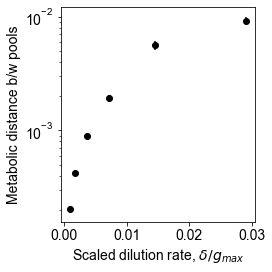

In [122]:
avg_pwise_dist=[]
avg_dist_to_theory=[]
stderrm_pwise_dist=[]
stderrm_dist_to_theory=[]
avg_rel_Rss=[]
stderr_rel_Rss=[]
min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(sim_data_df)
for idx, val in enumerate(analysis_df['exp_conditions_list']):
    exp_label='expt'+ str(idx)        
    Rss_arrs=np.array(analysis_df[exp_label]['Rss_list'])
    Rss_arrs[Rss_arrs<1e-5]=0
#     pwise_dists=distance.pdist(analysis_df[exp_label]['Rss_list'], 
#                                metric='jensenshannon')
    pwise_dists=distance.pdist(Rss_arrs, 
                               metric='jensenshannon')
    avg_pwise_dist.append(np.mean(pwise_dists))
    stderrm_pwise_dist.append(np.std(pwise_dists)/np.sqrt(len(pwise_dists)))
    R_ss_theory,  Flux_in_rxns, Flux_into_resource=calculate_Rss_and_fluxes_theory(min_DG_path_list, min_DG_list, sim_data_df,
                        n_resources=n_resources,Prediction_Order=1,
                        exp_label=exp_label)   
    dist_to_theory=[]
    for pool_id in range(analysis_df['number_of_pools']):
        dist_to_theory.append(distance.jensenshannon (
            R_ss_theory, Rss_arrs[pool_id])  )          
    avg_dist_to_theory.append(np.mean(dist_to_theory))
    stderrm_dist_to_theory.append(np.std(dist_to_theory)/np.sqrt(len(dist_to_theory)))
    
    rel_Rss_arrs=Rss_arrs/np.sum(Rss_arrs[0])
    avg_rel_Rss.append(np.mean(rel_Rss_arrs,axis=0))
    stderr_rel_Rss.append(np.std(rel_Rss_arrs,axis=0) /np.sqrt(len(Rss_arrs)) )
delta_vals=np.array(analysis_df['exp_conditions_list'])
nmzed_growth_rate=delta_vals/mean_gmax



fig = plt.figure(figsize=(4, 4))
ax1=fig.add_subplot()
ax1.errorbar(np.array(nmzed_growth_rate)[idx_to_plot] , np.array(avg_pwise_dist)[idx_to_plot],
             yerr=np.array(stderrm_pwise_dist)[idx_to_plot], fmt='ko')
ax1.set_yscale('log')
# ax1.set_xscale('log')
# print('ylim set')
if exp_suffix=='-expstyle5':
    ax1.set_ylim(1e-3, 1e-1)
    ax1.set_xticks([0., 0.02, 0.04, 0.06 ])

# ax1.errorbar([1e-3, 5e-1 ], [JSD_random_flux,JSD_random_flux], fmt='k--')
ax1.set_xlabel(r'Scaled dilution rate, $\delta/g_{max}$', fontsize=MEDIUM_SIZE-2)
ax1.set_ylabel('Metabolic distance b/w pools',fontsize=MEDIUM_SIZE-2)
fig.patch.set_facecolor('white')
plt.tight_layout()

plt.savefig(fig_folder+'JSD_RSS'+exp_suffix+'.pdf')
plt.show() 

# fig = plt.figure(figsize=(10, 5))
# ax1=fig.add_subplot(1,2,1)
# ax2=fig.add_subplot(1,2,2)

# ax2.plot(nmzed_growth_rate,1.-np.array(avg_dist_to_theory), 'go', label= 'dist from theory')


# ax2.set_ylim(0.0,1.02)
# ax2.set_xscale('log')
# ax2.plot(nmzed_growth_rate,1.-np.array(avg_dist_to_theory), 'go', label= 'dist from theory')
# ax2.set_xlabel(r'normalized growth rate, $\delta/ \langle g_{max} \rangle$')
# ax2.set_ylabel('convergence to predicted fluxes')



# fig.patch.set_facecolor('white')
# plt.tight_layout()
# # plt.savefig(fig_folder+'functional_convergence_to_theory-delta.pdf')
# plt.show() 

In [21]:
delta_vals

array([0.0025, 0.005 , 0.01  , 0.02  , 0.04  , 0.08  , 0.16  ])

In [162]:
analysis_df['exp_conditions_list']

array([0.0156, 0.0312, 0.0625, 0.25  , 0.5   , 1.    , 2.    ])

In [24]:
nmzed_growth_rate

array([0.00090909, 0.00181818, 0.00363636, 0.00727273, 0.01454545,
       0.02909091, 0.05818182])

## CV of resource concentrations

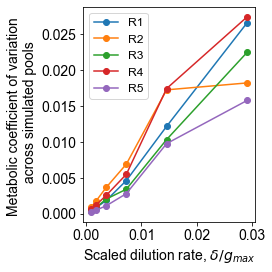

In [33]:
n_pools=sim_data_df['number_of_pools']
n_exp=sim_data_df['number_of_experiments']
n_res=6

R_ss_dict={'id':[]}

R_means_list=[]
R_stds_list=[]
for idx, val in enumerate(analysis_df['exp_conditions_list']):
    exp_label='expt'+ str(idx)
    Rss_list=[]
    for pidx in range(n_pools):
        pool_label='pool'+ str(pidx) 
        Rss=sim_data_df[pool_label][exp_label]['SS_values'][1]
        Rss_list.append(Rss)
    Rss_arr=np.array( Rss_list)
    Rss_arr[ Rss_arr<1e-5]=0
    Rmeans=np.mean(np.array(Rss_arr),axis=0)
    Rstds=np.std(np.array(Rss_arr),axis=0)
#     print (exp_label)
#     print (Rss_list)
    R_means_list.append(Rmeans)
    R_stds_list.append(Rstds)
R_means_list=np.array(R_means_list)
# R_means_list[R_means_list<1e-5]=0
R_CV_arr=np.array(R_stds_list)/np.array(R_means_list)
delta_vals=np.array(analysis_df['exp_conditions_list'])
nmzed_growth_rate=delta_vals/mean_gmax

fig= plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()
for ridx in range(1,n_res):
    ax1.plot(np.array(nmzed_growth_rate)[idx_to_plot], 
             R_CV_arr[idx_to_plot,ridx],'-o', label='R'+str(ridx))
# ax1.set_xscale('log')
# ax1.set_yscale('log')
# print ('ytickset')
# ax1.set_yticks([0.,0.05, 0.1, 0.15, 0.2 ])
# ax1.set_yticks([0.,0.04,0.08,0.12])
if exp_suffix=='-expstyle5':
    ax1.set_yticks([0.,0.05,0.1])
    ax1.set_xticks([0.,0.02, 0.04,0.06 ])
ax1.set_xlabel(r'Scaled dilution rate, $\delta/g_{max}$',fontsize=MEDIUM_SIZE-2)
ax1.set_ylabel('Metabolic coefficient of variation \n across simulated pools',
               fontsize=MEDIUM_SIZE-2)
ax1.legend(loc='best', fontsize=SMALL_SIZE-2)
fig.patch.set_facecolor('white')
plt.tight_layout()

plt.savefig(fig_folder+'CV_RSS'+exp_suffix+'.pdf')
plt.show()

In [29]:
delta_vals

array([0.0025, 0.005 , 0.01  , 0.02  , 0.04  , 0.08  , 0.16  ])

In [17]:
analysis_df['exp_conditions_list']

array([0.00625, 0.0125 , 0.025  , 0.05   , 0.1    , 0.2    , 0.4    ,
       0.8    ])

## PCA plot

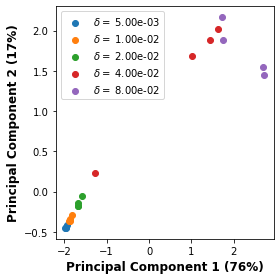

In [14]:
flux_dict={'id':[] }
for i in range(analysis_df['n_reactions']):
    flux_dict.update({'rxn'+str(i):[]})

for idx, val in enumerate(analysis_df['exp_conditions_list']):
    exp_label='expt'+ str(idx)        
    n_replicates=len(analysis_df[exp_label]['flux_in_community_list'])
    for j in range(n_replicates):
        flux_dict['id'].append(exp_label+'_rep'+str(j))
        flux_in_community=analysis_df[exp_label]['flux_in_community_list'][j]
        
        for i in range(analysis_df['n_reactions']):
            flux_dict['rxn'+str(i)].append(flux_in_community[i])
                             
flux_df=pd.DataFrame(flux_dict)
flux_df=flux_df.set_index('id')   


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_st =  StandardScaler().fit_transform(flux_df)
pca_out = PCA(n_components=2).fit(df_st)
pca_vals=pca_out.transform(df_st)


expt_id_list=[]
for ind in flux_df.index:
    expt_id_list.append( int(ind.split('_')[0].replace('expt','')) )

n_expts=len(analysis_df['exp_conditions_list'] )
fig= plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()

for expt_id in range(1,6):
    idxs=np.where(np.array(expt_id_list)==expt_id)[0]
    ax1.scatter(pca_vals[idxs,0],pca_vals[idxs,1],
                label=r'$\delta=$ {:.2e}'.format(analysis_df['exp_conditions_list'][expt_id]   ))

    
    ax1.set_xlabel('Principal Component 1 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[0]*100))
    ax1.set_ylabel('Principal Component 2 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[1]*100))
ax1.legend(loc='best')
fig.patch.set_facecolor('white')
plt.tight_layout()

plt.savefig(fig_folder+'PCA_plot_stdscaled'+exp_suffix+'.pdf')

plt.show()

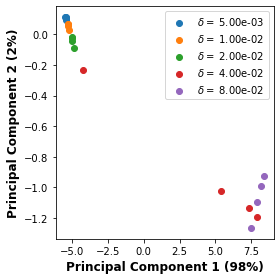

In [13]:
flux_dict={'id':[] }
for i in range(analysis_df['n_reactions']):
    flux_dict.update({'rxn'+str(i):[]})

for idx, val in enumerate(analysis_df['exp_conditions_list']):
    exp_label='expt'+ str(idx)        
    n_replicates=len(analysis_df[exp_label]['flux_in_community_list'])
    for j in range(n_replicates):
        flux_dict['id'].append(exp_label+'_rep'+str(j))
        flux_in_community=analysis_df[exp_label]['flux_in_community_list'][j]
        
        for i in range(analysis_df['n_reactions']):
            flux_dict['rxn'+str(i)].append(flux_in_community[i])
                             
flux_df=pd.DataFrame(flux_dict)
flux_df=flux_df.set_index('id')   


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca_out = PCA(n_components=2).fit(flux_df)
pca_vals=pca_out.transform(flux_df)


expt_id_list=[]
for ind in flux_df.index:
    expt_id_list.append( int(ind.split('_')[0].replace('expt','')) )

n_expts=len(analysis_df['exp_conditions_list'] )
fig= plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()

for expt_id in range(1,6):
    idxs=np.where(np.array(expt_id_list)==expt_id)[0]
    ax1.scatter(pca_vals[idxs,0],pca_vals[idxs,1],
                label=r'$\delta=$ {:.2e}'.format(analysis_df['exp_conditions_list'][expt_id]   ))

    
    ax1.set_xlabel('Principal Component 1 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[0]*100))
    ax1.set_ylabel('Principal Component 2 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[1]*100))
ax1.legend(loc='best')
fig.patch.set_facecolor('white')
plt.tight_layout()

plt.savefig(fig_folder+'PCA_plot_Notscaled'+exp_suffix+'.pdf')

plt.show()

#### parameters in sims

In [11]:
base_fold='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/cluster/'
# data_folder=base_fold+'S6_dilution_ExpStyle5/'
# exp_suffix='-expstyle5'
data_folder=base_fold+'S6_dilution_ExpStyle2/'
exp_suffix='-expstyle2'

sim_file_name='sim_dilution.dat'
analysis_file_name = 'analysis_'+sim_file_name
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

sim_data_df['pool0']['expt0']['params']

{'m': 0.00625,
 'reaction_network_type': 'all',
 'Energies': array([5., 4., 3., 2., 1., 0.]),
 'K_P': array([0.9736883 , 1.11802345, 1.14277438, 1.23984892, 1.0469076 ,
        0.98023289, 1.0043637 , 1.11018008, 1.05417932, 0.97011498,
        1.22053146, 0.99107941, 0.85013422, 0.91783107, 0.94275282]),
 'K_S': array([0.8274243 , 1.00772666, 1.19820293, 1.0305926 , 1.01559572,
        0.86341267, 1.0971074 , 1.13737707, 1.19054412, 0.99919876,
        0.93452846, 0.91962223, 0.82836999, 1.31597434, 1.10847019]),
 'Kcat': array([0.69688639, 1.29066586, 1.2545006 , 1.08353442, 0.85032894,
        1.05916438, 1.14384274, 1.20913309, 1.15154808, 1.08211083,
        0.97068011, 1.00890659, 0.9198624 , 1.27495079, 0.93897981]),
 'assumptions': {'nu_constraint': 'uniform_lognormal',
  'growth_type': 'thermodynamic_inhibition',
  'ATP_allocation': 'fATP_list',
  'fATP_list': array([0.55924781, 0.67994016, 0.48802272, 0.54706976, 0.34345378,
         0.45869557, 0.55469341, 0.42688083, 0.5963

In [12]:
np.random.lognormal(0, 0.01, 15)

array([1.0048511 , 1.00471439, 1.0007997 , 1.00770445, 0.9944406 ,
       0.99151611, 0.98635232, 0.98829558, 1.01957371, 1.00734953,
       0.99004956, 0.99120041, 1.00448079, 0.99060032, 1.00104567])

# Fig 6 varying Energy of resources



## reaction network panels

(array([ 0,  2,  5, 12, 14]),)
0
2
5
12
14


/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


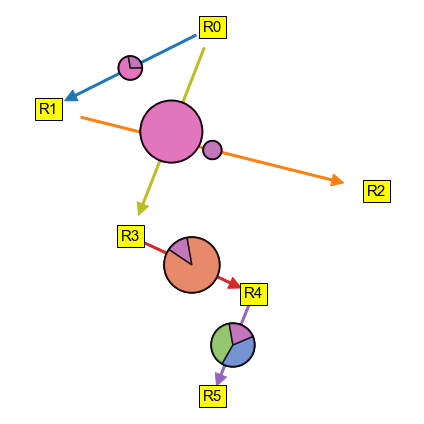

1.0


In [26]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_varyE.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id=0
pool_id=3

n_resources=6
fig_folder=dest_folder+'/Fig_vs_energy_scale/'
nwk_fig_folder=fig_folder+'/Network_figs/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
if not os.path.exists(nwk_fig_folder): os.mkdir(nwk_fig_folder)
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(sim_data_df)
flat_list = [item for sublist in min_DG_path_list for item in sublist]
rxns_predicted=np.unique(flat_list)

color_list=get_color_list(n_resources,rxn_idxs=rxns_predicted)
color_list[9]=color_list[6]
color_list[2]=color_list[8]



n_pools=sim_data_df['number_of_pools']
exp_conditions_list=analysis_df['exp_conditions_list']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']
expt_df = analysis_df['expt'+str(expt_id)]
exp_condition=exp_conditions_list[expt_id]

reactions_in_survivors = np.array(expt_df['reactions_in_final_survivors_list'][pool_id])
fluxes_by_survivors_arr = np.array(expt_df['fluxes_by_survivors_list'][pool_id])
fluxes_in_community=np.array(expt_df['flux_in_community_list'])[pool_id]
area_scale_factor=np.sum(fluxes_in_community)/4
# area_scale_factor=10

rel_flux_cutoff=1e-5
h,w=0.15,0.15
print(np.where(fluxes_in_community>0))


fig= plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
resources_dict =get_resource_nwk_positions(n_resources)     

taxa_colors=np.array(get_taxa_colors())
for reaction in range(n_reactions): 
#     if reaction in rxns_predicted:
#         ax1.annotate('',xy=(resources_dict[products[reaction]]),
#                              xytext=(resources_dict[substrates[reaction]]),
#                              arrowprops=dict(color='grey', shrink=0.1,width=4, linestyle=':'))       
    
    if fluxes_in_community[reaction]>0.0: 
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(color=color_list[reaction], shrink=0.1,width=2))       
        x,y=(np.array(resources_dict[products[reaction]])+         
                     np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2 
        idx_sp=np.nonzero(reactions_in_survivors[:,reaction])[0]## species that have the reaction
        weights=np.squeeze(fluxes_by_survivors_arr[idx_sp,reaction])
        pie_radius=np.sqrt(np.sum(weights)/area_scale_factor)  
#         donut_radius=pie_radius+.35
        if np.sum(weights)>rel_flux_cutoff:
            ax_inset=ax1.inset_axes([x,y, h,w])
            weighted_fracs=np.squeeze(weights/np.sum(weights))
            if len(idx_sp)==1:
                weighted_fracs=np.array(weighted_fracs).reshape(1)
            
            #### first circle with white background to not see arrows through 
            ###the transparent part of the donut
            ax_inset.pie([1.],
                         colors='white',radius=pie_radius,wedgeprops = {
                                        'linewidth': 2,'edgecolor':'k'})          
            ax_inset.pie(weighted_fracs,
                         colors=taxa_colors[n_pools*idx_sp+pool_id],
                    radius=pie_radius, startangle=100,wedgeprops = {"alpha": taxa_alpha,
                                        'linewidth': 1.5,'edgecolor':'k'})
            
#             ax_inset.pie([1.],
#                          colors=color_list[reaction:],
#                     radius=pie_radius,wedgeprops = {'linewidth': 1,'edgecolor':'k'})
            print(reaction)
        
#     else: 
#         ax1.annotate('',xy=(resources_dict[products[reaction]]),
#                              xytext=(resources_dict[substrates[reaction]]),
#                              arrowprops=dict(facecolor='black', shrink=0.075,
#                                              linestyle='dashed',width=1,alpha=.1))
        
for key,val in resources_dict.items():                 
    ax1.text(val[0],val[1],'R'+str(key), color='black',
             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center',
            fontname='Arial') 
ax1.set_xticks([])  
ax1.set_yticks([])  
ax1.axis('off')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(nwk_fig_folder+'/rxn_nwk-expt_'+str(expt_id)+'E0_'+str(exp_condition)+'-pool'+str(pool_id)+'.pdf')
plt.savefig(nwk_fig_folder+'/rxn_nwk-expt_'+str(expt_id)+'E0_'+str(exp_condition)+'-pool'+str(pool_id)+'.png')
plt.show()
print(exp_condition)

## plot accuracy of prediction and flux convergence

/Users/ashish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in true_divide


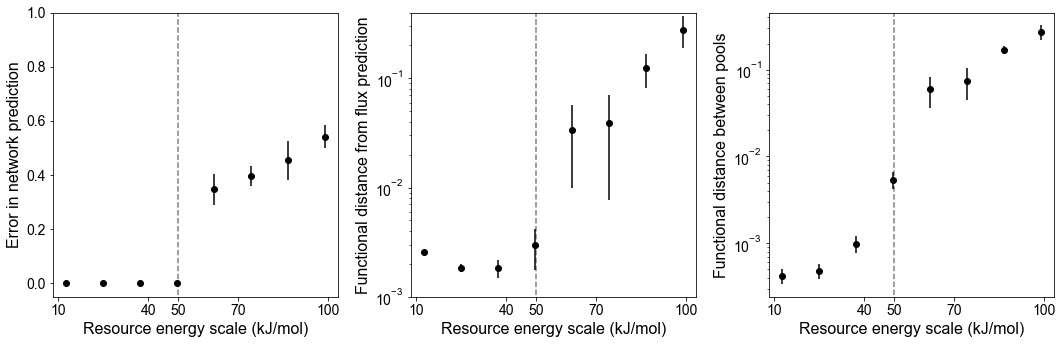

In [3]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_varyE.dat'
analysis_file_name = 'analysis_'+sim_file_name
fig_folder=dest_folder+'/Fig_vs_energy_scale/'
expt_id=0
pool_id=3

n_resources=6
fig_folder=dest_folder+'/Fig_vs_energy_scale/'
nwk_fig_folder=fig_folder+'/Network_figs/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
if not os.path.exists(nwk_fig_folder): os.mkdir(nwk_fig_folder)
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

RT_val=2.479 ## kJ/mol
exp_id_to_val_factor=5
E_R0=5
rel_flux_cutoff=1e-4    
pool_ids=np.arange(4).astype(int)    
param_varied='Escale'
verbose=False

n_resources=analysis_df['n_resources']
n_reactions=analysis_df['n_reactions']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
exp_conditions_list = analysis_df['exp_conditions_list']
n_pools=len(pool_ids)
color_list=create_color_list(scheme_name='sns_deep')
n_exp_conditions=len(exp_conditions_list)

results_dict={'exp_conditions_list':exp_conditions_list,
                 'param_varied':param_varied,
                 'n_pools':n_pools,
                 'exp_condition_txts':[],
                 'deviation_from_theory_flux_avg':[],
                 'deviation_from_theory_flux_stderr':[],
                 'deviation_from_theory_nwk_avg':[],
                 'deviation_from_theory_nwk_stderr':[],
                 'avg_pwise_dist':[],
                 'stderr_pwise_dist':[],
                 'avg_nwk_similarity':[],
                 'stderr_nwk_similarity':[]
                 }

for expt_id, exp_condition in enumerate(exp_conditions_list):
    exp_label='expt'+str(expt_id)
    
    results_dict['exp_condition_txts'].append(str(int(exp_condition)*E_R0))
#     results_dict['exp_condition_txts'].append(
#         get_exp_condition_txt(param_varied,exp_condition,analysis_df))           
    min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(
        sim_data_df, exp_label=exp_label, pool_label='pool0')
    R_ss_0th,  Flux_in_rxns_0th, Flux_into_resource_0th=calculate_Rss_and_fluxes_theory(
        min_DG_path_list, min_DG_list, sim_data_df,n_resources=n_resources,
        Prediction_Order=0,exp_label=exp_label, pool_label='pool0')

    deviation_from_theory_flux=[]
    deviation_from_theory_nwk=[]
    nwk_similarity=[]
    for pool_ctr, pool_id in enumerate(pool_ids):
        flux_in_sim_i=analysis_df[exp_label]['flux_in_community_list'][pool_ctr]
        deviation_from_theory_flux.append(distance.jensenshannon (Flux_in_rxns_0th, 
                                                             flux_in_sim_i  ))          
        rxns_present_th=np.zeros_like(Flux_in_rxns_0th)
        rxns_present_obs=np.zeros_like(Flux_in_rxns_0th)
        rxns_present_th[ (Flux_in_rxns_0th/ Flux_in_rxns_0th.sum() )>rel_flux_cutoff]=1
        rxns_present_obs[(flux_in_sim_i/flux_in_sim_i.sum() )>rel_flux_cutoff]=1
        deviation_from_theory_nwk.append(distance.hamming (rxns_present_th, 
                                                             rxns_present_obs  ))                   
        
        ## calculate nwk accuracy using measure in Fig.4
        flat_list = [item for sublist in min_DG_path_list for item in sublist]
        rxns_predicted=np.unique(flat_list)
        rxns_realized=np.nonzero(flux_in_sim_i)[0]
        
        n_rxns_correct=len(np.intersect1d(rxns_realized,rxns_predicted)) ##A intersect B
        n_tot_rxns=len(rxns_realized)+ len(rxns_predicted)-n_rxns_correct ## A union B
        nwk_similarity.append(n_rxns_correct*1./n_tot_rxns)
        
        
        if verbose:
            print ('expt', expt_id)
            print (flux_in_sim_i)         
    results_dict['deviation_from_theory_flux_avg'].append(
        np.mean(deviation_from_theory_flux))
    results_dict['deviation_from_theory_flux_stderr'].append(
        np.std(deviation_from_theory_flux)/np.sqrt(n_pools)  )
    results_dict['deviation_from_theory_nwk_avg'].append(
        np.mean(deviation_from_theory_nwk))
    results_dict['deviation_from_theory_nwk_stderr'].append(
        np.std(deviation_from_theory_nwk)/np.sqrt(n_pools)  )

    ##compute flux convergence from each other rather than theory 
    pwise_dists=distance.pdist(analysis_df[exp_label]['flux_in_community_list'], 
                           metric='jensenshannon')
    results_dict['avg_pwise_dist'].append(np.mean(pwise_dists))
    results_dict['stderr_pwise_dist'].append(np.std(pwise_dists)/np.sqrt(len(pwise_dists)))
    
    
    results_dict['avg_nwk_similarity'].append(np.mean(nwk_similarity))
    results_dict['stderr_nwk_similarity'].append(np.std(nwk_similarity)/np.sqrt(len(nwk_similarity)))



    if verbose:
        print (Flux_in_rxns_0th)
        print (min_DG_path_list)

#             print ('expt', expt_id)
        print (np.mean(deviation_from_theory_flux))
        print (np.mean(deviation_from_theory_nwk))

        print (results_dict['exp_condition_txts'])  
### matching xticks in exptids to expvals in RT and then xtickvals in kJ  
# xtickvals_in_kJ=np.array([0,25,50,75,100])
xtickvals_in_kJ=np.array([10,40,50,70,100])
xtickvals_in_RT=xtickvals_in_kJ/RT_val
exp_vals=np.array([int(k) for k in results_dict['exp_condition_txts']])
assert np.array_equal(exp_vals,exp_id_to_val_factor*np.array(exp_conditions_list)),'expt id and vals were not linearly related as expected'
xticks_in_ids=xtickvals_in_RT/exp_id_to_val_factor
id_val_at_50kJ=50/(RT_val*exp_id_to_val_factor)    

fig = plt.figure(figsize=(15, 5))

ax1=fig.add_subplot(1,3,1)
# ax1.plot(exp_conditions_list, 
#          results_dict['deviation_from_theory_nwk_avg'], 'go')

### for plotting accuracy
# ax1.errorbar(exp_conditions_list, results_dict['avg_nwk_similarity'], 
#              yerr= results_dict['stderr_nwk_similarity'],
#              fmt='ko')
# ax1.set_ylim(0,1.05)

### for plotting error
ax1.errorbar(exp_conditions_list,1- np.asarray(results_dict['avg_nwk_similarity']), 
             yerr= results_dict['stderr_nwk_similarity'],
             fmt='ko')
ax1.set_ylim(-0.05,1.0)


ax1.axvline(id_val_at_50kJ,-0.05,1.0,linestyle='dashed', color='k',alpha=.5)

ax1.set_xticks(xticks_in_ids)
ax1.set_xticklabels(xtickvals_in_kJ)
# ax1.set_xlim(0,8.5)
### original xticks
# ax1.set_xticks(exp_conditions_list)
# ax1.set_xticklabels(results_dict['exp_condition_txts'])


ax2=fig.add_subplot(1,3,2)
ax2.set_ylim(1e-3,4e-1)
ax2.set_yscale('log')
# ax2.plot(exp_conditions_list, 
#          results_dict['deviation_from_theory_flux_avg'], 'bo')
ax2.errorbar(exp_conditions_list, results_dict['deviation_from_theory_flux_avg'], 
             yerr= results_dict['deviation_from_theory_flux_stderr'],
             fmt='ko')

ax2.axvline(id_val_at_50kJ,-0.05,1.0,linestyle='dashed', color='k',alpha=.5)
ax2.set_xticks(xticks_in_ids)
ax2.set_xticklabels(xtickvals_in_kJ)
# ax2.set_xlim(0,8.5)
# ax2.set_xticks(exp_conditions_list)
# ax2.set_xticklabels(results_dict['exp_condition_txts'])


ax3=fig.add_subplot(1,3,3)
ax3.set_yscale('log')
# ax3.plot(exp_conditions_list, 
#          results_dict['avg_pwise_dist'], 'bo')
ax3.errorbar(exp_conditions_list, results_dict['avg_pwise_dist'], 
             yerr= results_dict['stderr_pwise_dist'],
             fmt='ko')
ax3.axvline(id_val_at_50kJ,-0.05,1.0,linestyle='dashed', color='k',alpha=.5)
ax3.set_xticks(xticks_in_ids)
ax3.set_xticklabels(xtickvals_in_kJ)
# ax3.set_xlim(0,8.5)
# ax3.set_xticks(exp_conditions_list)
# ax3.set_xticklabels(results_dict['exp_condition_txts'])

# ax1.set_ylabel('Accuracy of predicted network')
ax1.set_ylabel('Error in network prediction')
ax2.set_ylabel('Functional distance from flux prediction')
ax3.set_ylabel('Functional distance between pools')

ax2.set_xlabel('Resource energy scale (kJ/mol)')
ax1.set_xlabel('Resource energy scale (kJ/mol)')
ax3.set_xlabel('Resource energy scale (kJ/mol)')


fig.patch.set_facecolor('white')
plt.tight_layout()

# plt.savefig(fig_folder+'Fig_deviation_Escale.pdf')
# plt.savefig(fig_folder+'Fig_deviation_Escale.png')

plt.show() 



In [6]:
exp_conditions_list

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [11]:
exp_vals=np.array([int(k) for k in results_dict['exp_condition_txts']])
exp_vals

array([ 5, 10, 15, 20, 25, 30, 35, 40])

In [4]:
results_dict['avg_nwk_similarity']

[1.0,
 1.0,
 1.0,
 1.0,
 0.6535714285714286,
 0.6035714285714286,
 0.5461309523809523,
 0.45803571428571427]

In [10]:
np.array(exp_vals)==5*np.array(exp_conditions_list)

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
# OLD Version..
# def plot_flux_nwk_prediction_accuracy(analysis_df,sim_data_df,pool_ids=np.arange(1).astype(int),
#                                       param_varied='',rel_flux_cutoff=1e-4,verbose=False,
#                                      return_results=False, suppress_plots=False):
#     n_resources=analysis_df['n_resources']
#     n_reactions=analysis_df['n_reactions']
#     substrates=analysis_df['reaction_substrates']
#     products=analysis_df['reaction_products']
#     exp_conditions_list = analysis_df['exp_conditions_list']
#     n_pools=len(pool_ids)
#     color_list=create_color_list(scheme_name='sns_deep')
#     n_exp_conditions=len(exp_conditions_list)
    
#     results_dict={'exp_conditions_list':exp_conditions_list,
#                  'param_varied':param_varied,
#                  'n_pools':n_pools,
#                  'exp_condition_txts':[],
#                  'deviation_from_theory_flux_avg':[],
#                  'deviation_from_theory_flux_stderr':[],
#                  'deviation_from_theory_nwk_avg':[],
#                  'deviation_from_theory_nwk_stderr':[],
#                  'avg_pwise_dist':[],
#                  'stderr_pwise_dist':[] 
#                  }

#     for expt_id, exp_condition in enumerate(exp_conditions_list):
#         exp_label='expt'+str(expt_id)
#         results_dict['exp_condition_txts'].append(
#             get_exp_condition_txt(param_varied,exp_condition,analysis_df))           
#         min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(
#             sim_data_df, exp_label=exp_label, pool_label='pool0')
#         R_ss_0th,  Flux_in_rxns_0th, Flux_into_resource_0th=calculate_Rss_and_fluxes_theory(
#             min_DG_path_list, min_DG_list, sim_data_df,n_resources=n_resources,
#             Prediction_Order=0,exp_label=exp_label, pool_label='pool0')
        
#         deviation_from_theory_flux=[]
#         deviation_from_theory_nwk=[]
#         for pool_ctr, pool_id in enumerate(pool_ids):
#             flux_in_sim_i=analysis_df[exp_label]['flux_in_community_list'][pool_ctr]
#             deviation_from_theory_flux.append(distance.jensenshannon (Flux_in_rxns_0th, 
#                                                                  flux_in_sim_i  ))          
#             rxns_present_th=np.zeros_like(Flux_in_rxns_0th)
#             rxns_present_obs=np.zeros_like(Flux_in_rxns_0th)
#             rxns_present_th[ (Flux_in_rxns_0th/ Flux_in_rxns_0th.sum() )>rel_flux_cutoff]=1
#             rxns_present_obs[(flux_in_sim_i/flux_in_sim_i.sum() )>rel_flux_cutoff]=1
#             deviation_from_theory_nwk.append(distance.hamming (rxns_present_th, 
#                                                                  rxns_present_obs  ))                   
#             if verbose:
#                 print ('expt', expt_id)
#                 print (flux_in_sim_i)         
#         results_dict['deviation_from_theory_flux_avg'].append(
#             np.mean(deviation_from_theory_flux))
#         results_dict['deviation_from_theory_flux_stderr'].append(
#             np.std(deviation_from_theory_flux)/np.sqrt(n_pools)  )
#         results_dict['deviation_from_theory_nwk_avg'].append(
#             np.mean(deviation_from_theory_nwk))
#         results_dict['deviation_from_theory_nwk_stderr'].append(
#             np.std(deviation_from_theory_nwk)/np.sqrt(n_pools)  )
        
#         ##compute flux convergence from each other rather than theory 
#         pwise_dists=distance.pdist(analysis_df[exp_label]['flux_in_community_list'], 
#                                metric='jensenshannon')
#         results_dict['avg_pwise_dist'].append(np.mean(pwise_dists))
#         results_dict['stderr_pwise_dist'].append(np.std(pwise_dists)/np.sqrt(len(pwise_dists)))

            
            
#         if verbose:
#             print (Flux_in_rxns_0th)
#             print (min_DG_path_list)

# #             print ('expt', expt_id)
#             print (np.mean(deviation_from_theory_flux))
#             print (np.mean(deviation_from_theory_nwk))
        
#             print (results_dict['exp_condition_txts'])  
    
#     if suppress_plots is False:
#         fig = plt.figure(figsize=(15, 5))
#         ax1=fig.add_subplot(1,3,1)
#     #     ax1.set_ylim(0.0,1.02)
#         ax1.set_yscale('log')
#         ax1.plot(exp_conditions_list, 
#                  results_dict['deviation_from_theory_flux_avg'], 'bo')
#         ax1.set_xticks(exp_conditions_list)
#         ax1.set_xticklabels(results_dict['exp_condition_txts'],rotation=90)

#         ax2=fig.add_subplot(1,3,2)
#         ax2.plot(exp_conditions_list, 
#                  results_dict['deviation_from_theory_nwk_avg'], 'bo')
#         ax2.set_xticks(exp_conditions_list)
#         ax2.set_xticklabels(results_dict['exp_condition_txts'],rotation=90)
        
#         ax3=fig.add_subplot(1,3,3)
#         ax3.set_yscale('log')
#         ax3.plot(exp_conditions_list, 
#                  results_dict['avg_pwise_dist'], 'bo')
#         ax3.set_xticks(exp_conditions_list)
#         ax3.set_xticklabels(results_dict['exp_condition_txts'],rotation=90)


#         ax1.set_ylabel('deviation from predicted fluxes, JSD')
#         ax2.set_ylabel('deviation from predicted network, Hamming')
#         ax3.set_ylabel('divergence in fluxes between pools, JSD')
        
#         fig.patch.set_facecolor('white')
#         plt.tight_layout()
#         plt.show() 
    
#     if return_results:
#         return results_dict
    
    
    



## calculate avg similarity of random spanning tree and theory

fixes one spanning tree for the "prediction" and then randomly generates many spanning trees in the metabolic network as observations. And then computes the expected network similarity


based on the results below, we will use a value of .315

In [89]:
## read some folder to get a list of 6 species products
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_varyE.dat'
analysis_file_name = 'analysis_'+sim_file_name
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
products=analysis_df['reaction_products']


n_resources=6
dummy_rxns_predicted=np.arange(5) ## say prediction is all products produced directly from R0
nwk_similarity=[]
ncorrect_list=[]
n_random_trees=10000
for k in range(n_random_trees):
#     print ('rep',k)
    ## simulate random prediction.
    dummy_rxns_observed=[]
    for i in range (1,n_resources):
        rxn_ids=np.where(products==i)[0]
        rxn_chosen=np.random.choice(rxn_ids)
        dummy_rxns_observed.append(rxn_chosen)

#     print (dummy_rxns_observed)
#     print (np.intersect1d(dummy_rxns_observed,dummy_rxns_predicted))
    n_rxns_correct=len(np.intersect1d(dummy_rxns_observed,dummy_rxns_predicted)) ##A intersect B
#     print (n_rxns_correct)
    n_tot_rxns=len(dummy_rxns_observed)+ len(dummy_rxns_predicted)-n_rxns_correct ## A union B
    nwk_similarity.append(n_rxns_correct*1./n_tot_rxns)
    ncorrect_list.append(n_rxns_correct)

print ('nreplicates=',n_random_trees)  
print ('average similarity between random spanning tree and predicted spanning tree= ', np.mean(nwk_similarity))
print ('std error= ', np.std(nwk_similarity)/np.sqrt(n_random_trees)  )
# print (nwk_similarity)        

nreplicates= 10000
average similarity between random spanning tree and predicted spanning tree=  0.3156146825396825
std error=  0.0016818915259084112


##### alternate code that simulates spanning tree more explicity gives same result

In [120]:
## read some folder to get a list of 6 species products
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_varyE.dat'
analysis_file_name = 'analysis_'+sim_file_name
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
products=analysis_df['reaction_products']
substrates=analysis_df['reaction_substrates']

n_resources=6
dummy_rxns_predicted=np.arange(5) ## say prediction is all products produced directly from R0
nwk_similarity=[]
ncorrect_list=[]
n_random_trees=10000
for k in range(n_random_trees):
#     print ('rep',k)
    ## simulate random prediction.
    allowed_substrates=[0]
    dummy_rxns_observed=[]
    for p in range (1,n_resources):
        rxn_ids_with_product_p=np.where(products==p)[0]
        rxn_ids_with_allowed_substrates=[]
        for s in allowed_substrates:
            rxn_ids_with_allowed_substrates.extend(np.where(substrates==s)[0])

        rxn_ids=np.intersect1d(rxn_ids_with_product_p, np.array(rxn_ids_with_allowed_substrates))
#         print (rxn_ids_with_product_p)
#         print (rxn_ids_with_allowed_substrates)
#         print (rxn_ids)
        rxn_chosen=np.random.choice(rxn_ids)
        
        dummy_rxns_observed.append(rxn_chosen)
        if products[rxn_chosen] not in allowed_substrates: ## add the product to list of allowed substrates
            allowed_substrates.append(products[rxn_chosen])


    n_rxns_correct=len(np.intersect1d(dummy_rxns_observed,dummy_rxns_predicted)) ##A intersect B
    n_tot_rxns=len(dummy_rxns_observed)+ len(dummy_rxns_predicted)-n_rxns_correct ## A union B
    nwk_similarity.append(n_rxns_correct*1./n_tot_rxns)
    ncorrect_list.append(n_rxns_correct)

print ('nreplicates=',n_random_trees)  
print ('average similarity between random spanning tree and predicted spanning tree= ', np.mean(nwk_similarity))
print ('std error= ', np.std(nwk_similarity)/np.sqrt(n_random_trees)  )
# print (nwk_similarity)        

nreplicates= 10000
average similarity between random spanning tree and predicted spanning tree=  0.3149253968253968
std error=  0.0016686967674621033


# SI fig making different rxns irreversible

Actually makes reactions "quasi irreversible" not really irreversible. just sets delta G to a predetermined large value of O(10RT)

In [27]:
def plot_fig_convergence_across_worlds(filename_prefix,n_worlds,data_folder,n_pools=4,
                                      fig_name=None):
    expected_random_nwk_similarity=0.315
    deviation_from_theory_flux_avgs=[]
    deviation_from_theory_nwk_avgs=[]
    avg_pwise_flux_dists=[]
    avg_nwk_similaritys=[]
    stderr_nwk_similaritys=[]
    stderr_pwise_flux_dists=[]
    for world_id in range(n_worlds): 
        sim_file_name=filename_prefix+'-w'+str(world_id)+'.dat'
        analysis_file_name = 'analysis_'+sim_file_name
        with open(data_folder+analysis_file_name, 'rb') as f:
            analysis_df = pickle.load(f)
        with open(data_folder+sim_file_name, 'rb') as f:
            sim_data_df = pickle.load(f)
        
        results_i=plot_flux_nwk_prediction_accuracy(analysis_df,sim_data_df,param_varied ='irr_reaction',
                                          pool_ids=np.arange(n_pools).astype(int),
                                        return_results=True,
                                         suppress_plots=True)
        deviation_from_theory_flux_avgs.append(results_i['deviation_from_theory_flux_avg'])
        deviation_from_theory_nwk_avgs.append(results_i['deviation_from_theory_nwk_avg'])
        avg_pwise_flux_dists.append(results_i['avg_pwise_dist'])
        avg_nwk_similaritys.append(results_i['avg_nwk_similarity'])
        stderr_nwk_similaritys.append(results_i['stderr_nwk_similarity'])
        stderr_pwise_flux_dists.append(results_i['stderr_pwise_dist'])
        
        if world_id==0:
            exp_conditions_list=results_i['exp_conditions_list']
            exp_condition_txts=results_i['exp_condition_txts']
            param_varied=results_i['param_varied']
            exp_condition_txts=np.array(exp_condition_txts)
    
    
    substrates=analysis_df['reaction_substrates']
    products=analysis_df['reaction_products']
    avg_Ridx=(products+substrates)/2.
    ordr=np.lexsort((substrates,avg_Ridx))
    ordr_array=ordr+1## ignore the first one.
    
#     ordr_array=np.arange(len(exp_conditions_list)-1)+1
    
    ## Plot everythign except the reversible reaction network which is the first exptal condition
    fig = plt.figure(figsize=(10, 5))
    xticks=np.arange(len(exp_conditions_list)-1) ## don't plot the first reaction!
    ordered_yvals=np.mean(avg_nwk_similaritys,axis=0)[ordr_array]
    ## find the variances of the nwk similarities across pools, then take the mean and then divided by sqrt for stderr
    ordered_yerrs=np.sqrt(np.mean(np.square(stderr_nwk_similaritys)*n_pools,axis=0
                                 )/n_worlds)[ordr_array]
    ax1=fig.add_subplot(1,2,1)
#     ax1.plot(xticks, 
#              ordered_yvals, 'bo')
    ax1.errorbar(xticks,ordered_yvals, yerr= ordered_yerrs,
             fmt='ko')
    
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(exp_condition_txts[ordr_array],rotation=90)
    rho=stats.spearmanr(xticks,
                        ordered_yvals)
#     print ('correlation of ', xticks ,'and',ordered_yvals   )
#     print (stats.spearmanr(xticks,
#                         np.mean(avg_nwk_similaritys,axis=0)[ordr_array]))

    
    ax1.text(.1,.32, r'$\rho$={:.2f}'.format(rho[0])
            ,transform=ax1.transAxes)
    ax1.text(.04,.08, 'expected accurracy with random network'.format(rho[0])
            ,transform=ax1.transAxes)
#     ax1.text(.1,.07, r'p= {:.2f}'.format(rho[1])
#             ,transform=ax1.transAxes)
    ax1.set_ylim(0.2,1)
    ax1.axhline(y=expected_random_nwk_similarity,xmin=ax1.get_xlim()[0],xmax=ax1.get_xlim()[1],
                linestyle='--', color='k')
    print ("pvalue1 =", rho[1])
    
    
    ax2=fig.add_subplot(1,2,2)
    ordered_yvals= np.mean(avg_pwise_flux_dists,axis=0)[ordr_array]
    
    ordered_yerrs=np.sqrt(np.mean(np.square(stderr_pwise_flux_dists)*n_pools,axis=0
                                 )/n_worlds)[ordr_array]
#     ax2.plot(xticks, 
#              ordered_yvals, 'bo')
    ax2.errorbar(xticks,ordered_yvals, yerr= ordered_yerrs,
             fmt='ko')
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(exp_condition_txts[ordr_array],rotation=90)
    
    rho=stats.spearmanr(xticks,
                        ordered_yvals)
    ax2.text(.8,.12, r'$\rho$={:.2f}'.format(rho[0]) 
            ,transform=ax2.transAxes)
    
#     ax2.text(.1,.07, r'p= {:.2f}'.format(rho[1])
#             ,transform=ax2.transAxes)
    print ("pvalue2 =",rho[1]) 
    

    ax1.set_ylabel('Accuracy of predicted network')
    ax2.set_ylabel('Functional distance between pools  ')
    ax1.set_xlabel('Reactions by network position', labelpad=12)
    ax2.set_xlabel('Reactions by network position', labelpad=12)
    
#     plt.suptitle(title)
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    if fig_name is not None:
        plt.savefig(fig_name)
    plt.show() 
        
        
    
   

/Users/ashish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in true_divide


pvalue1 = 0.04983923347142064
pvalue2 = 0.006509956694715437


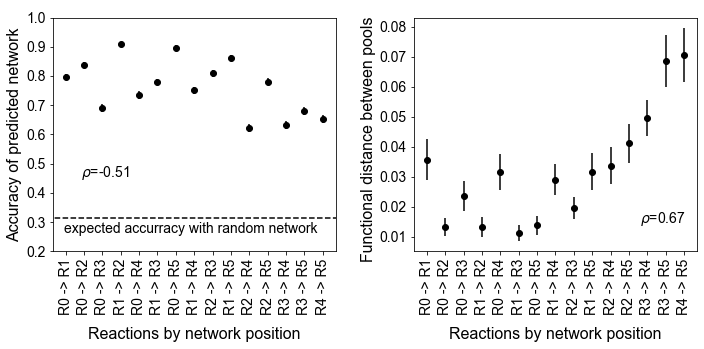

In [28]:
fig_folder=dest_folder+'/Fig_SI_varying_irr_rxns/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)



data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/cluster/S6_1irr_2/'
n_worlds=50
filename_prefix='sim_1irr'
plot_fig_convergence_across_worlds(filename_prefix,n_worlds,data_folder,
                                   fig_name=fig_folder+'fig_varying_irrRxn_2.pdf'
                                  )

/Users/ashish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:293: RuntimeWarning: divide by zero encountered in true_divide


pvalue1 = 0.014833955405976968
pvalue2 = 0.04983923347142064


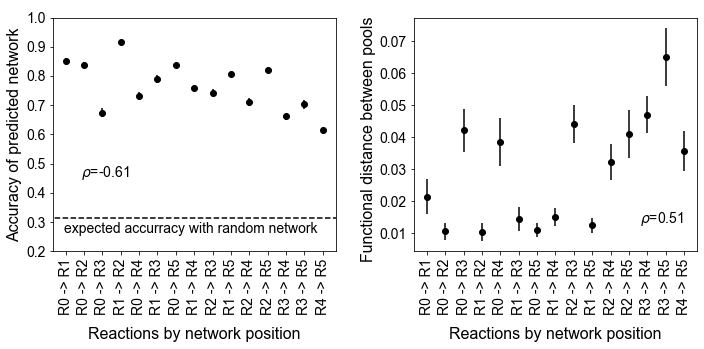

In [29]:
fig_folder=dest_folder+'/Fig_SI_varying_irr_rxns/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)



data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/cluster/S6_1irr_3/'
n_worlds=50
filename_prefix='sim_1irr'
plot_fig_convergence_across_worlds(filename_prefix,n_worlds,data_folder,
                                   fig_name=fig_folder+'fig_varying_irrRxn_3.pdf'
                                  )


# SI figure on anabolism, no Rdilution model

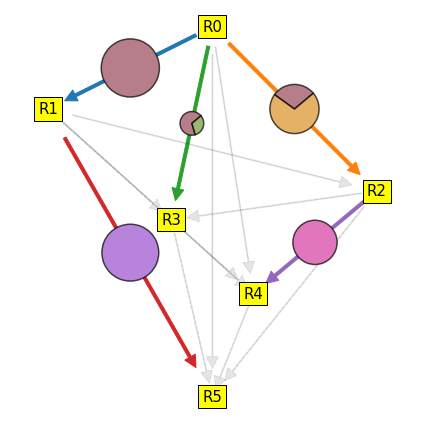

In [11]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_anabolism_noRdilution.dat'
analysis_file_name = 'analysis_'+sim_file_name

with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)
    
expt_id='0'
fig_folder=dest_folder+'/Fig_SI_anabolism_noRdilution/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)


n_pools=sim_data_df['number_of_pools']
exp_conditions_list = analysis_df['exp_conditions_list']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']

expt_df = analysis_df['expt'+str(expt_id)]
pool_id=2

reactions_in_survivors = np.array(expt_df['reactions_in_final_survivors_list'][pool_id])
fluxes_by_survivors_arr = np.array(expt_df['fluxes_by_survivors_list'][pool_id])
fluxes_in_community0=np.array(expt_df['flux_in_community_list'])[pool_id]
area_scale_factor=3
h,w=0.15,0.15


fig= plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
resources_dict =get_resource_nwk_positions(n_resources)   
resources_dict.update({3:[0.4, .48]})
# ={0:[0.5, .95],1:[0.1, .75],
#                        2:[0.9, .55],                      
#                        3:[0.3, .44], 4:[0.6, .3],
#                        5:[0.5, .05]} 

color_list=get_color_list(n_resources,rxn_idxs=np.where(fluxes_in_community0>0)[0])
taxa_colors=np.array(get_taxa_colors())
for reaction in range(n_reactions): 
    if fluxes_in_community0[reaction]>0.0: 
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(color=color_list[reaction], shrink=0.1,width=3))       
        x,y=(np.array(resources_dict[products[reaction]])+         
                     np.array(resources_dict[substrates[reaction]])-np.array([h,w]))/2 
        idx_sp=np.nonzero(reactions_in_survivors[:,reaction])[0]## species that have the reaction
        weights=np.squeeze(fluxes_by_survivors_arr[idx_sp,reaction])
        pie_radius=np.sqrt(np.sum(weights)/area_scale_factor)  
        if np.sum(weights)>1e-2:
            ax_inset=ax1.inset_axes([x,y, h,w])
            weighted_fracs=np.squeeze(weights/np.sum(weights))
            if len(idx_sp)==1:
                weighted_fracs=np.array(weighted_fracs).reshape(1)
#             ax_inset.pie(weighted_fracs, autopct='%1.f%%',pctdistance=.6,
#                          colors=taxa_colors[n_pools*idx_sp+pool_id],
#                     radius=pie_radius, startangle=40,wedgeprops = {"alpha": taxa_alpha},
#                         textprops={"fontsize":10})
            ax_inset.pie([1.],
                     colors='white',radius=pie_radius)
            ax_inset.pie(weighted_fracs,
                         colors=taxa_colors[n_pools*idx_sp+pool_id],
                    radius=pie_radius, startangle=40,wedgeprops = {"alpha": taxa_alpha,
                                        'linewidth': 1.5,'edgecolor':'k'},
                        )
    else:
        ax1.annotate('',xy=(resources_dict[products[reaction]]),
                             xytext=(resources_dict[substrates[reaction]]),
                             arrowprops=dict(facecolor='black', shrink=0.075,
                                             linestyle='dashed',width=1,alpha=.1))
        
for key,val in resources_dict.items():                 
    ax1.text(val[0],val[1],'R'+str(key), color='black',
             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center') 
ax1.set_xticks([])  
ax1.set_yticks([])  
ax1.axis('off')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(fig_folder+'rxn_nwk_fluxes_and_taxa'+str(pool_id)+'.pdf')
plt.savefig(fig_folder+'rxn_nwk_fluxes_and_taxa'+str(pool_id)+'.png')

plt.show()

/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:269: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


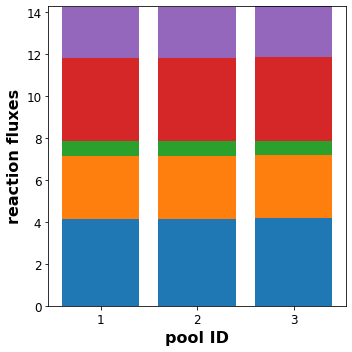

In [21]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_anabolism_noRdilution.dat'
analysis_file_name = 'analysis_'+sim_file_name

with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)
    
expt_id='0'
fig_folder=dest_folder+'/Fig_SI_anabolism_noRdilution/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)

n_pools=sim_data_df['number_of_pools']
exp_conditions_list = analysis_df['exp_conditions_list']
reaction_substrates = analysis_df['reaction_substrates']
reaction_products = analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']


fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot()
expt_df = analysis_df['expt'+str(expt_id)]
xlabels=[str(pool+1) for pool in range(n_pools)]
fluxes_in_community_arr=np.array(expt_df['flux_in_community_list'])
## get theory prediction
# min_DG_path_list,min_DG_list=get_max_dissipative_rxn_paths(sim_data_df)
min_DG_path_list, min_DG_list, DGvals_on_paths=get_max_dissipative_rxn_paths(sim_data_df)
R_ss,  Flux_in_rxns, Flux_into_resource=calculate_Rss_and_fluxes_theory(min_DG_path_list, min_DG_list, sim_data_df,
                                    n_resources=6,Prediction_Order=0)


##### add theory prediction
# print('using zeroth order prediction')
# fluxes_in_community_arr=np.append(fluxes_in_community_arr,[Flux_in_rxns],axis=0)
# xlabels.append('')


flux_idx=np.where(fluxes_in_community_arr[0]>0)[0]
color_list=get_color_list(n_resources,rxn_idxs=flux_idx)#list(sns.color_palette(palette='deep',n_colors=n_reactions))



ax1.bar(xlabels,fluxes_in_community_arr[:,0],color=color_list[0])
bottom=fluxes_in_community_arr[:,0]
for i in range(n_reactions-1):                   
    ax1.bar(xlabels,fluxes_in_community_arr[:,i+1],
            bottom=bottom,color=color_list[i+1])
    bottom+=fluxes_in_community_arr[:,i+1]
ax1.set_xlabel('pool ID',fontSize=BIGGER_SIZE+2)
ax1.set_ylabel('reaction fluxes',fontSize=BIGGER_SIZE+2) 
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim(0,2.04)
# ax1.set_yticks([0,0.5,1.,1.5,2.])
fig.patch.set_facecolor('white')   
plt.tight_layout()
# plt.savefig(fig_folder+'bar_plot_fluxes.pdf')
# plt.savefig(fig_folder+'bar_plot_fluxes.png')
plt.savefig(fig_folder+'bar_plot_fluxes_without_theory.pdf')
plt.savefig(fig_folder+'bar_plot_fluxes_without_theory.png')
plt.show()


######bar plot of taxa #############
# survivor_abundance_list=expt_df['abundance_of_survivors']
# n_species=n_resources-1 ## fixed to make an array.
# survivor_abundance_arr=np.zeros((n_pools,n_species))
# survivor_rel_abundance_arr=np.zeros((n_pools,n_species))
# for pool in range(n_pools):
#     n_survivors=len(survivor_abundance_list)
#     survivor_abundance_arr[pool,:n_survivors]=survivor_abundance_list[pool]
#     survivor_rel_abundance_arr[pool]= survivor_abundance_arr[pool]/np.sum(survivor_abundance_arr[pool])  
# xlabels=[str(pool+1) for pool in range(n_pools)]
# taxa_colors=np.array(get_taxa_colors())

# fig = plt.figure(figsize=(5,5))
# ax1 = fig.add_subplot()
# ax1.bar(xlabels,survivor_rel_abundance_arr[:,0],color=taxa_colors[0:n_pools], alpha=taxa_alpha)
# bottom=survivor_rel_abundance_arr[:,0]
# for i in range(1,n_species):   
#     ax1.bar(xlabels,survivor_rel_abundance_arr[:,i],
#             bottom=bottom,color=taxa_colors[n_pools*i:n_pools*(i+1)], alpha=taxa_alpha)
#     bottom+=survivor_rel_abundance_arr[:,i]
# ax1.set_xlabel('pool ID',fontSize=BIGGER_SIZE+2)
# ax1.set_ylabel('relative abundance of taxa',fontSize=BIGGER_SIZE+2) 
# ax1.tick_params(axis='both', which='major', labelsize=12)
# fig.patch.set_facecolor('white')   
# plt.tight_layout()
# plt.savefig(fig_folder+'bar_plot_taxa.pdf')
# plt.savefig(fig_folder+'bar_plot_taxa.png')
plt.show()


In [17]:
n_reactions

15

In [19]:
color_list

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

In [15]:
flux_idx

array([ 0,  1,  2,  8, 10])

# SI Fig dynamicY

(array([ 0,  2,  4,  5, 10]),)
0
2
4
5
10


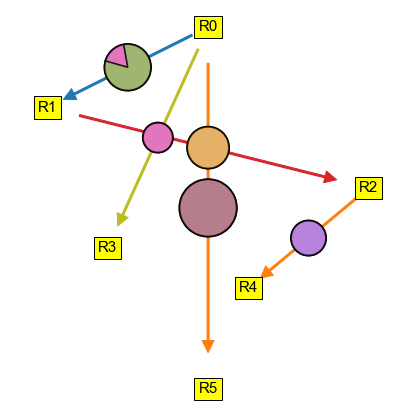

[80.  0.  0.  0.  0.  0.]


In [27]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='dynamicY1.dat'
analysis_file_name = 'analysis_'+sim_file_name
expt_id=0
pool_id=2

n_resources=6
fig_folder=dest_folder+'/Fig_dynamic_yield/'
nwk_fig_folder=fig_folder+'/Network_figs/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
if not os.path.exists(nwk_fig_folder): os.mkdir(nwk_fig_folder)
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)

min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(sim_data_df)
flat_list = [item for sublist in min_DG_path_list for item in sublist]
rxns_predicted=np.unique(flat_list)

color_list=get_color_list(n_resources,rxn_idxs=rxns_predicted)
color_list[9]=color_list[6]
color_list[2]=color_list[8]



n_pools=sim_data_df['number_of_pools']
exp_conditions_list=analysis_df['exp_conditions_list']
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']
n_resources = analysis_df['n_resources']
n_reactions = analysis_df['n_reactions']
expt_df = analysis_df['expt'+str(expt_id)]
exp_condition=exp_conditions_list[expt_id]

reactions_in_survivors = np.array(expt_df['reactions_in_final_survivors_list'][pool_id])
fluxes_by_survivors_arr = np.array(expt_df['fluxes_by_survivors_list'][pool_id])
fluxes_in_community=np.array(expt_df['flux_in_community_list'])[pool_id]
area_scale_factor=np.sum(fluxes_in_community)/4
# area_scale_factor=10

rel_flux_cutoff=1e-5
h,w=0.15,0.15
print(np.where(fluxes_in_community>0))


fig= plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
resources_dict1 =get_resource_nwk_positions(n_resources)     
## update resouce positions in this figure to prevent overlap    
resources_dict1[3]=[0.25, 0.4] 
 

taxa_colors=np.array(get_taxa_colors())
for reaction in range(n_reactions): 
#     if reaction in rxns_predicted:
#         ax1.annotate('',xy=(resources_dict1[products[reaction]]),
#                              xytext=(resources_dict1[substrates[reaction]]),
#                              arrowprops=dict(color='grey', shrink=0.1,width=4, linestyle=':'))       
    
    if fluxes_in_community[reaction]>0.0: 
        ax1.annotate('',xy=(resources_dict1[products[reaction]]),
                             xytext=(resources_dict1[substrates[reaction]]),
                             arrowprops=dict(color=color_list[reaction], shrink=0.1,width=2))       
        x,y=(np.array(resources_dict1[products[reaction]])+         
                     np.array(resources_dict1[substrates[reaction]])-np.array([h,w]))/2 
        idx_sp=np.nonzero(reactions_in_survivors[:,reaction])[0]## species that have the reaction
        weights=np.squeeze(fluxes_by_survivors_arr[idx_sp,reaction])
        pie_radius=np.sqrt(np.sum(weights)/area_scale_factor)  
#         donut_radius=pie_radius+.35
        if np.sum(weights)>rel_flux_cutoff:
            ax_inset=ax1.inset_axes([x,y, h,w])
            weighted_fracs=np.squeeze(weights/np.sum(weights))
            if len(idx_sp)==1:
                weighted_fracs=np.array(weighted_fracs).reshape(1)
            
            #### first circle with white background to not see arrows through 
            ###the transparent part of the donut
            ax_inset.pie([1.],
                         colors='white',radius=pie_radius,wedgeprops = {
                                        'linewidth': 2,'edgecolor':'k'})          
            ax_inset.pie(weighted_fracs,
                         colors=taxa_colors[n_pools*idx_sp+pool_id],
                    radius=pie_radius, startangle=100,wedgeprops = {"alpha": taxa_alpha,
                                        'linewidth': 1.5,'edgecolor':'k'})
            
#             ax_inset.pie([1.],
#                          colors=color_list[reaction:],
#                     radius=pie_radius,wedgeprops = {'linewidth': 1,'edgecolor':'k'})
            print(reaction)
        
#     else: 
#         ax1.annotate('',xy=(resources_dict1[products[reaction]]),
#                              xytext=(resources_dict1[substrates[reaction]]),
#                              arrowprops=dict(facecolor='black', shrink=0.075,
#                                              linestyle='dashed',width=1,alpha=.1))
        
for key,val in resources_dict1.items():                 
    ax1.text(val[0],val[1],'R'+str(key), color='black',
             bbox=dict(facecolor='yellow', edgecolor='k'),fontsize=15,ha='center',va='center',
            fontname='Arial') 
ax1.set_xticks([])  
ax1.set_yticks([])  
ax1.axis('off')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(nwk_fig_folder+'/rxn_nwk-expt_'+str(expt_id)+'-pool'+str(pool_id)+'.pdf')
plt.savefig(nwk_fig_folder+'/rxn_nwk-expt_'+str(expt_id)+'-pool'+str(pool_id)+'.png')
plt.show()
print(exp_condition)

In [4]:
resources_dict

{0: [0.5, 0.95],
 1: [0.1, 0.75],
 2: [0.9, 0.55],
 3: [0.3, 0.44],
 4: [0.6, 0.3],
 5: [0.5, 0.05]}

In [6]:
resources_dict[5]

[0.5, 0.05]

# read exptal data Peces et al

In [11]:
df_exp=pd.read_excel('/Users/ashish/Dropbox/research/Sergei/peces data digester HRT/manual data table.xlsx',
                    header=[0,1])

df_exp=df_exp.drop(0)## remove OLR row since we don't care about it right now
digester_names=['SL','SS', 'PL', 'BG']
HRT_vals=[15,8,4,2]
df_exp.head()

Digester    SL                      SS                       PL        \
          HRT    15     8     4     2    15     8      4     2    15     8   
1        tVFA  18.0  12.0  72.4  55.1  18.7  11.8  138.0  67.2  18.6  13.0   
2     Acetate  12.4  12.3  34.5  13.2  12.1   7.4   72.7  33.7  10.9   8.3   
3  Propionate   2.1   3.5  30.3  33.5   2.3   1.8   51.6  25.6   2.9   1.3   
4    Butyrate   1.4   1.0   2.9   4.2   1.5   0.8    7.6   3.5   1.8   0.7   
5    Valerate   1.5   1.2   4.4   4.3   1.6   1.0    5.4   4.1   2.5   1.0   

                 BG                    
      4     2    15     8     4     2  
1  69.6  28.8  21.0  10.2  21.6  11.7  
2  20.8   9.8  14.6   7.7  11.5   8.0  
3  40.9  14.2   3.0   1.0   7.8   2.2  
4   3.7   1.5   1.9   0.7   1.2   0.5  
5   3.2   2.2   2.2   0.7   1.1   0.7

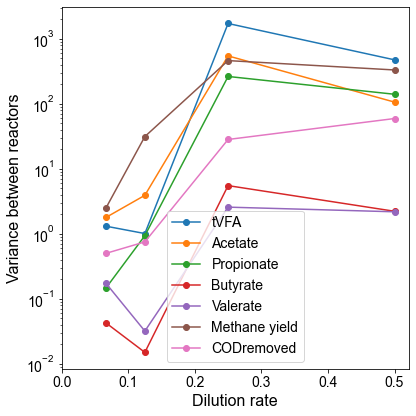

In [12]:
fnames_list=['tVFA', 'Acetate', 'Propionate','Butyrate', 'Valerate',
             'Methane yield', 'CODremoved' ]
fig= plt.figure(figsize=(6,6))
ax1 = fig.add_subplot()
for fname in fnames_list:
    var_list=[]
    for HRT in HRT_vals:
        vals=[]
        for digester in digester_names:
            vals.append( float(df_exp[df_exp['Digester']['HRT']==fname][digester][HRT].values) )
        var_list.append(np.var(vals))
        
    ax1.plot(1./np.array(HRT_vals), var_list,'-o', label=fname)
ax1.set_yscale('log')
ax1.set_xlabel('Dilution rate')
ax1.set_ylabel('Variance between reactors')
ax1.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax1.legend(loc='best')
fig.patch.set_facecolor('white')
plt.tight_layout()
fig_folder='/Users/ashish/Dropbox/research/Sergei/simple metabolic CR model/figures/Fig_exptal_data/'
plt.savefig(fig_folder+'functionVariance-dilutionrate.pdf')
plt.show()

## plot CoeffVar vs dilution rate 

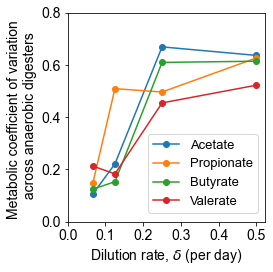

In [27]:
# fnames_list=['tVFA', 'Acetate', 'Propionate','Butyrate', 'Valerate',
#              'Methane yield', 'CODremoved' ]
fnames_list=['Acetate', 'Propionate','Butyrate', 'Valerate']
labels_list=['Acetate', 'Propionate','Butyrate', 'Valerate']
fig= plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()
for i, fname in enumerate(fnames_list):
    var_list=[]
    mean_list=[]
    for HRT in HRT_vals:
        vals=[]
        for digester in digester_names:
            vals.append( float(df_exp[df_exp['Digester']['HRT']==fname][digester][HRT].values) )
        var_list.append(np.var(vals))
        mean_list.append(np.mean(vals))
    ax1.plot(1./np.array(HRT_vals), np.sqrt(var_list)/np.array(mean_list),'-o', 
             label=labels_list[i])
ax1.set_ylim([0, .8])
ax1.set_yticks([0., 0.2,0.4, 0.6, 0.8])
# ax1.set_yscale('log')
# ax1.set_ylim([.9e-1, 1.04])
# ax1.set_yticks([1e-1,3e-1, 9e-1])

ax1.set_xticks([0.,0.1, 0.2, .3,.4, .5])
ax1.set_xlabel(r'Dilution rate, $\delta$ (per day)',fontSize=MEDIUM_SIZE-2)
ax1.set_ylabel('Metabolic coefficient of variation \n across anaerobic digesters',
               fontSize=MEDIUM_SIZE-2)
# ax1.legend(loc='best')
ax1.legend(loc='upper right', bbox_to_anchor=(1.0,0.45),fontsize=SMALL_SIZE-1)
fig.patch.set_facecolor('white')
plt.tight_layout()
fig_folder='/Users/ashish/Dropbox/research/Sergei/simple metabolic CR model/figures/Fig_exptal_data/'
plt.savefig(fig_folder+'CV_Rss-dilutionrate.pdf')
plt.show()

## plot JSD vs dilution rate

In [28]:
df_sub=df_exp.drop(1) ## remove tVFA as well since we are assaying each VFA separately
df_sub=df_sub.drop(7) ## remove COD as well
df_sub.head(9)

Digester     SL                          SS                       \
             HRT     15      8      4      2     15      8      4      2   
2        Acetate   12.4   12.3   34.5   13.2   12.1    7.4   72.7   33.7   
3     Propionate    2.1    3.5   30.3   33.5    2.3    1.8   51.6   25.6   
4       Butyrate    1.4    1.0    2.9    4.2    1.5    0.8    7.6    3.5   
5       Valerate    1.5    1.2    4.4    4.3    1.6    1.0    5.4    4.1   
6  Methane yield  277.0  240.0  214.0  163.0  280.0  226.0  174.0  126.0   

      PL                          BG                       
      15      8      4      2     15      8      4      2  
2   10.9    8.3   20.8    9.8   14.6    7.7   11.5    8.0  
3    2.9    1.3   40.9   14.2    3.0    1.0    7.8    2.2  
4    1.8    0.7    3.7    1.5    1.9    0.7    1.2    0.5  
5    2.5    1.0    3.2    2.2    2.2    0.7    1.1    0.7  
6  278.0  239.0  223.0  172.0  281.0  237.0  229.0  167.0

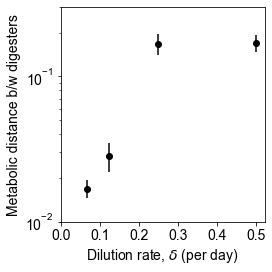

In [30]:
JSD_list=[]
JSD_stderr_list=[]
for HRT in HRT_vals:
    flux_array=[]
    for digester in digester_names:
        flux_array.append(df_sub[digester][HRT].values)
    flux_array=np.array(flux_array)
    pwise_dists=distance.pdist(flux_array, metric='jensenshannon')
    JSD_list.append(np.mean(pwise_dists))
    JSD_stderr_list.append(np.std(pwise_dists)/np.sqrt(len(pwise_dists)))
fig= plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()
# ax1.plot(1./np.array(HRT_vals), JSD_list,'ko')
ax1.errorbar(1./np.array(HRT_vals) , JSD_list, yerr=JSD_stderr_list, fmt='ko')
ax1.set_yscale('log')
ax1.set_xlabel(r'Dilution rate, $\delta$ (per day)',fontSize=MEDIUM_SIZE-2)
ax1.set_ylabel('Metabolic distance b/w digesters',fontSize=MEDIUM_SIZE-2)
ax1.set_ylim(1e-2, 3e-1)
ax1.set_xticks([0.,0.1, 0.2, .3,.4, .5])
fig.patch.set_facecolor('white')
plt.tight_layout()
fig_folder='/Users/ashish/Dropbox/research/Sergei/simple metabolic CR model/figures/Fig_exptal_data/'
plt.savefig(fig_folder+'metabolic_distance-dilutionrate.pdf')
plt.show()

## PCA plot

In [246]:
#### to merge the muliindex columns to have a nicer data frame with unique column names
df_temp=pd.read_excel('/Users/ashish/Dropbox/research/Sergei/peces data digester HRT/manual data table.xlsx',
                    header=[0,1])
df_temp=df_temp.drop([0,1,7] ) ## remove tvfa, COD because not independent
# df_temp=df_temp.drop([0])
df_exp2=df_temp.copy()
df_exp2.columns = df_exp2.columns.map('{0[0]}_{0[1]}'.format) 
df_exp2=df_exp2.set_index('Digester_HRT')
df_exp2.head()
df_exp_T = df_exp2.T
df_exp_T.head()  

Digester_HRT,Acetate,Propionate,Butyrate,Valerate,Methane yield
SL_15,12.4,2.1,1.4,1.5,277.0
SL_8,12.3,3.5,1.0,1.2,240.0
SL_4,34.5,30.3,2.9,4.4,214.0
SL_2,13.2,33.5,4.2,4.3,163.0
SS_15,12.1,2.3,1.5,1.6,280.0


##### with standard scaling

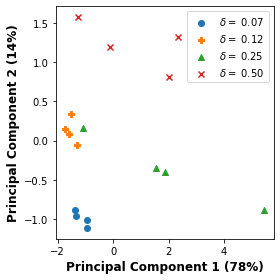

In [247]:
hrt_id_list=[]
for ind in df_exp_T.index:
    for i, hrt in enumerate(HRT_vals):
        if str(hrt) in ind:
            hrt_id_list.append(i)
color_list=list(sns.color_palette(palette='tab10'))
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
## rescaling variation in all the axis
df_st =  StandardScaler().fit_transform(df_exp_T)
pca_out = PCA(n_components=2).fit(df_st)
pca_vals=pca_out.transform(df_st)

marker_format=['o','P','^', 'x']
fig= plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()

for hrt_id in range(4):
    idxs=np.where(np.array(hrt_id_list)==hrt_id)[0]
    ax1.scatter(pca_vals[idxs,0],pca_vals[idxs,1],marker=marker_format[hrt_id],
                label=r'$\delta=$ {:.2f}'.format(1./HRT_vals[hrt_id]))

ax1.set_xlabel('Principal Component 1 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[0]*100))
ax1.set_ylabel('Principal Component 2 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[1]*100))
ax1.legend(loc='best')
fig.patch.set_facecolor('white')
plt.tight_layout()
fig_folder='/Users/ashish/Dropbox/research/Sergei/simple metabolic CR model/figures/Fig_exptal_data/'
plt.savefig(fig_folder+'PCA_plot_stdscaled.pdf')

plt.show()

In [165]:
hrt_id

3

##### witout standard scaling

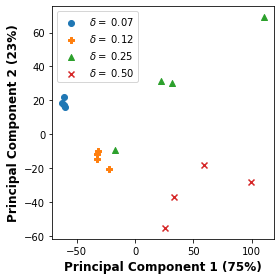

In [209]:
hrt_id_list=[]
for ind in df_exp_T.index:
    for i, hrt in enumerate(HRT_vals):
        if str(hrt) in ind:
            hrt_id_list.append(i)
color_list=list(sns.color_palette(palette='tab10'))
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_out = PCA(n_components=2).fit(df_exp_T)
pca_vals=pca_out.transform(df_exp_T)

marker_format=['o','P','^', 'x']
fig= plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()

for hrt_id in range(4):
    idxs=np.where(np.array(hrt_id_list)==hrt_id)[0]
    ax1.scatter(pca_vals[idxs,0],pca_vals[idxs,1],marker=marker_format[hrt_id],
                label=r'$\delta=$ {:.2f}'.format(1./HRT_vals[hrt_id]))

ax1.set_xlabel('Principal Component 1 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[0]*100))
ax1.set_ylabel('Principal Component 2 ({:.0f}%)'.format(pca_out.explained_variance_ratio_[1]*100))
ax1.legend(loc='best')
fig.patch.set_facecolor('white')
plt.tight_layout()
fig_folder='/Users/ashish/Dropbox/research/Sergei/simple metabolic CR model/figures/Fig_exptal_data/'
plt.savefig(fig_folder+'PCA_plot_not_stdscaled.pdf')

plt.show()

In [168]:
np.where(np.array(hrt_id_list)==2)[0]

array([ 2,  6, 10, 14])

In [ ]:
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

array([0.75430194, 0.23115232])

# rough

In [119]:
## read some folder to get a list of 6 species products
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_varyE.dat'
analysis_file_name = 'analysis_'+sim_file_name
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
products=analysis_df['reaction_products']
substrates=analysis_df['reaction_substrates']

n_resources=6
dummy_rxns_predicted=np.arange(5) ## say prediction is all products produced directly from R0
nwk_similarity=[]
ncorrect_list=[]
n_random_trees=1000
for k in range(n_random_trees):
#     print ('rep',k)
    ## simulate random prediction.
    allowed_substrates=[0]
    dummy_rxns_observed=[]
    for p in range (1,n_resources):
        rxn_ids_with_product_p=np.where(products==p)[0]
        rxn_ids_with_allowed_substrates=[]
        for s in allowed_substrates:
            rxn_ids_with_allowed_substrates.extend(np.where(substrates==s)[0])

        rxn_ids=np.intersect1d(rxn_ids_with_product_p, np.array(rxn_ids_with_allowed_substrates))
#         print (rxn_ids_with_product_p)
#         print (rxn_ids_with_allowed_substrates)
#         print (rxn_ids)
        rxn_chosen=np.random.choice(rxn_ids)
        
        dummy_rxns_observed.append(rxn_chosen)
        if products[rxn_chosen] not in allowed_substrates: ## add the product to list of allowed substrates
            allowed_substrates.append(products[rxn_chosen])

#     print (dummy_rxns_observed)
#     print (np.intersect1d(dummy_rxns_observed,dummy_rxns_predicted))
    n_rxns_correct=len(np.intersect1d(dummy_rxns_observed,dummy_rxns_predicted)) ##A intersect B
#     print (n_rxns_correct)
    n_tot_rxns=len(dummy_rxns_observed)+ len(dummy_rxns_predicted)-n_rxns_correct ## A union B
    nwk_similarity.append(n_rxns_correct*1./n_tot_rxns)
    ncorrect_list.append(n_rxns_correct)

print ('nreplicates=',n_random_trees)  
print ('average similarity between random spanning tree and predicted spanning tree= ', np.mean(nwk_similarity))
print ('std error= ', np.std(nwk_similarity)/np.sqrt(n_random_trees)  )
# print (nwk_similarity)        

nreplicates= 1000
average similarity between random spanning tree and predicted spanning tree=  0.32251587301587303
std error=  0.0056180819892642396


In [90]:
## read some folder to get a list of 6 species products
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/multispecies_sims/'
sim_file_name='6sp_varyE.dat'
analysis_file_name = 'analysis_'+sim_file_name
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
products=analysis_df['reaction_products']


n_resources=6
dummy_rxns_predicted=np.arange(5) ## say prediction is all products produced directly from R0
nwk_similarity=[]
ncorrect_list=[]
for k in range(3):
    print ('rep',k)
    ## simulate random prediction.
    dummy_rxns_observed=[]
    for i in range (1,n_resources):
        rxn_ids=np.where(products==i)[0]
        rxn_chosen=np.random.choice(rxn_ids)
        dummy_rxns_observed.append(rxn_chosen)
        print (i,rxn_chosen)
        
#     print (dummy_rxns_observed)
#     print (np.intersect1d(dummy_rxns_observed,dummy_rxns_predicted))
    n_rxns_correct=len(np.intersect1d(dummy_rxns_observed,dummy_rxns_predicted)) ##A intersect B
#     print (n_rxns_correct)
    n_tot_rxns=len(dummy_rxns_observed)+ len(dummy_rxns_predicted)-n_rxns_correct ## A union B
    nwk_similarity.append(n_rxns_correct*1./n_tot_rxns)
    ncorrect_list.append(n_rxns_correct)

    
print ('average similarity=', np.mean(nwk_similarity))
# print (nwk_similarity)        

rep 0
1 0
2 1
3 2
4 12
5 4
rep 1
1 0
2 1
3 6
4 3
5 8
rep 2
1 0
2 5
3 9
4 7
5 8
average similarity= 0.4021164021164021


In [91]:
dummy_rxns_predicted

array([0, 1, 2, 3, 4])

In [67]:
np.nonzero(dummy_rxns_predicted)

(array([0, 1, 2, 3, 4]),)

In [55]:
dummy_rxns_observed

array([1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.])

In [68]:
np.arange(5)

array([0, 1, 2, 3, 4])

In [65]:
rxns_predicted

array([ 0,  1,  3,  9, 14])

In [66]:
rxns_realized

array([0, 1, 2, 3, 4])

In [ ]:
rxns_predicted=np.unique(flat_list)
# for idx, val in enumerate(analysis_df['exp_conditions_list']):
#     exp_label='expt'+ str(idx)    
#     nwk_similarity=[]
#     for pool_id in range(analysis_df['number_of_pools']):
#         flux_in_community=analysis_df[exp_label]['flux_in_community_list'][pool_id]
#         rxns_realized

In [48]:
np.random.choice(rxn_ids)

13

In [49]:
dummy_rxns_observed

array([1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [58]:
np.intersect1d(dummy_rxns_observed,dummy_rxns_predicted)

array([0., 1.])

In [31]:
n_rxns_correct

2

In [14]:
products[np.where(products==2)]

array([2, 2])

In [ ]:
np.append(np.)

In [15]:
np.where(products==2)[0]

array([1, 5])

In [5]:
analysis_df.keys()

dict_keys(['exp_conditions_list', 'expt0', 'expt1', 'expt2', 'expt3', 'expt4', 'expt5', 'expt6', 'expt7', 'reaction_substrates', 'reaction_products', 'n_resources', 'n_reactions', 'number_of_pools'])

In [6]:
analysis_df['reaction_substrates']

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4])

In [7]:
analysis_df['reaction_products']

array([1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5])

In [12]:
products[np.where(products==1)]

array([1])

In [6]:
np.shape(analysis_df[exp_label]['flux_in_community_list'])

(10, 15)

In [8]:
distance.pdist(analysis_df[exp_label]['flux_in_community_list'], 
                               metric='jensenshannon')

array([0.54887447, 0.43021501, 0.43565295, 0.42985188, 0.85870243,
       0.31684909, 0.27034348, 0.50186196, 0.35314883, 0.26541595])

In [44]:
np.shape(random_flux_list)

(100, 15)

0.3120027488151478

In [16]:
substrates=analysis_df['reaction_substrates']
products=analysis_df['reaction_products']

In [18]:
products

array([1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5])

In [13]:
np.mean(distance.pdist(analysis_df[exp_label]['flux_in_community_list'], 
                               metric='jensenshannon'))

0.1515064029760549

In [12]:
distance.pdist(analysis_df[exp_label]['flux_in_community_list'], 
                               metric='jensenshannon')

array([0.19318947, 0.20845094, 0.27326825, 0.16842973, 0.22329508,
       0.19073164, 0.25740853, 0.20240185, 0.22078727, 0.12093941,
       0.23616878, 0.11088936, 0.16111169, 0.12141206, 0.2366299 ,
       0.13535454, 0.15721739, 0.16672494, 0.12034899, 0.09973643,
       0.08261031, 0.18001243, 0.08595244, 0.11225269, 0.24106176,
       0.19981297, 0.1934699 , 0.24716772, 0.19601522, 0.20018309,
       0.11848611, 0.07649373, 0.17248127, 0.0905449 , 0.12770809,
       0.05278125, 0.12232552, 0.0324019 , 0.07894537, 0.14158529,
       0.02057578, 0.07992212, 0.13212046, 0.15281792, 0.07556364])

# SI figure, for file 3 where enzyme variability was highest..

/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:269: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/thermo/lib/python3.7/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


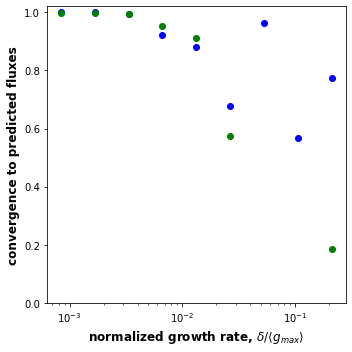

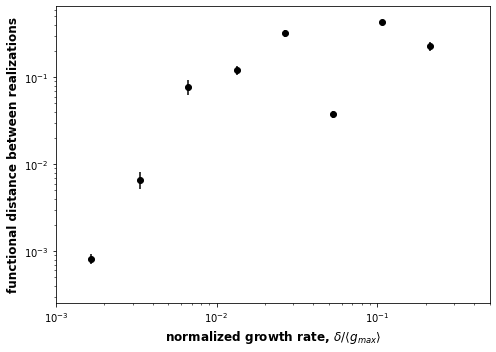

In [17]:
data_folder='/Users/ashish/Downloads/simple_metabolic_CR_model_simdata/cluster/S6_dilution_4/'
sim_file_name='sim_dilution.dat'
analysis_file_name = 'analysis_'+sim_file_name

fig_folder=dest_folder+'/Fig_vs_dilution_growth_rate/'
if not os.path.exists(fig_folder): os.mkdir(fig_folder)
    
# mean_gmax=2.73*1.011## for 3
mean_gmax=2.73*2.75 ## for 4
n_resources  =6
with open(data_folder+analysis_file_name, 'rb') as f:
    analysis_df = pickle.load(f)
with open(data_folder+sim_file_name, 'rb') as f:
    sim_data_df = pickle.load(f)
avg_pwise_dist=[]
avg_dist_to_theory=[]
stderrm_pwise_dist=[]
stderrm_dist_to_theory=[]
min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(sim_data_df)
for idx, val in enumerate(analysis_df['exp_conditions_list']):
    exp_label='expt'+ str(idx)        
    pwise_dists=distance.pdist(analysis_df[exp_label]['flux_in_community_list'], 
                               metric='jensenshannon')
    avg_pwise_dist.append(np.mean(pwise_dists))
    stderrm_pwise_dist.append(np.std(pwise_dists)/np.sqrt(len(pwise_dists)))
    R_ss,  Flux_in_rxns, Flux_into_resource=calculate_Rss_and_fluxes_theory(min_DG_path_list, min_DG_list, sim_data_df,
                        n_resources=n_resources,Prediction_Order=1,
                        exp_label=exp_label)     
    dist_to_theory=[]
    for pool_id in range(analysis_df['number_of_pools']):
        dist_to_theory.append(distance.jensenshannon (
            Flux_in_rxns, analysis_df[exp_label]['flux_in_community_list'][pool_id])  )          
    avg_dist_to_theory.append(np.mean(dist_to_theory))
    stderrm_dist_to_theory.append(np.std(dist_to_theory)/np.sqrt(len(dist_to_theory)))

    

delta_vals=np.array(analysis_df['exp_conditions_list'])
nmzed_growth_rate=delta_vals/mean_gmax
fig = plt.figure(figsize=(5, 5))
ax1=fig.add_subplot()
ax1.set_ylim(0.0,1.02)
ax1.set_xscale('log')
ax1.plot(nmzed_growth_rate, 1.-np.array(avg_pwise_dist), 'bo', label= 'dist b/w pools')
ax1.plot(nmzed_growth_rate,1.-np.array(avg_dist_to_theory), 'go', label= 'dist from theory')
ax1.set_xlabel(r'normalized growth rate, $\delta/ \langle g_{max} \rangle$')
ax1.set_ylabel('convergence to predicted fluxes')
fig.patch.set_facecolor('white')
plt.tight_layout()

plt.show() 



fig = plt.figure(figsize=(7, 5))
ax1=fig.add_subplot()
ax1.errorbar(nmzed_growth_rate , avg_pwise_dist, yerr=stderrm_pwise_dist, fmt='ko')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'normalized growth rate, $\delta/ \langle g_{max} \rangle$')
ax1.set_xlim(1e-3, 5e-1)
ax1.set_ylabel('functional distance between realizations')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(fig_folder+'functional_distance-delta-file4.pdf')

plt.show() 

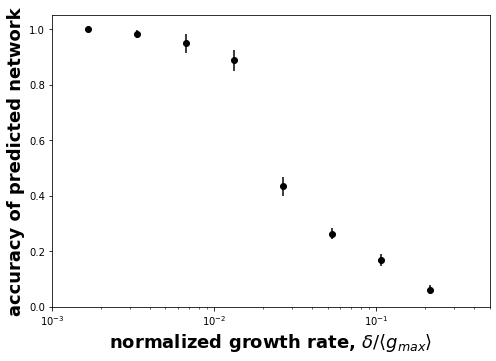

In [19]:
max_dissip_accuracy=[]
max_dissip_accuracy_stderrm=[]
min_DG_path_list,min_DG_list, DGvals_onpaths_list=get_max_dissipative_rxn_paths(sim_data_df)
flat_list = [item for sublist in min_DG_path_list for item in sublist]
rxns_predicted=np.unique(flat_list)
for idx, val in enumerate(analysis_df['exp_conditions_list']):
    exp_label='expt'+ str(idx)    
    nwk_similarity=[]
    for pool_id in range(analysis_df['number_of_pools']):
        flux_in_community=analysis_df[exp_label]['flux_in_community_list'][pool_id]
        rxns_realized=np.nonzero(flux_in_community)[0]
        n_rxns_correct=len(np.intersect1d(rxns_realized,rxns_predicted)) ##A intersect B
        n_tot_rxns=len(rxns_realized)+ len(rxns_predicted)-n_rxns_correct ## A union B
        nwk_similarity.append(n_rxns_correct*1./n_tot_rxns)
        
        
    max_dissip_accuracy.append(np.mean(nwk_similarity))
    max_dissip_accuracy_stderrm.append(np.std(nwk_similarity)/np.sqrt(len(nwk_similarity)))
    

    

delta_vals=np.array(analysis_df['exp_conditions_list'])
nmzed_growth_rate=delta_vals/mean_gmax
fig = plt.figure(figsize=(7, 5))
ax1=fig.add_subplot()
ax1.set_ylim(0.0,1.05)
ax1.set_xlim(1e-3, 5e-1)
ax1.set_xscale('log')
# ax1.plot(nmzed_growth_rate, max_dissip_accuracy, 'bo')
ax1.errorbar(nmzed_growth_rate, max_dissip_accuracy, yerr= max_dissip_accuracy_stderrm,
             fmt='ko')
ax1.set_xlabel(r'normalized growth rate, $\delta/ \langle g_{max} \rangle$',fontsize=BIGGEST_SIZE)
ax1.set_ylabel('accuracy of predicted network',fontsize=BIGGEST_SIZE)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(fig_folder+'max_dissip_accuracy-delta-file4.pdf')
plt.savefig(fig_folder+'max_dissip_accuracy-delta-highEnzymaticVariation.png')
plt.show() 



# fig = plt.figure(figsize=(5, 5))
# ax1=fig.add_subplot()
# ax1.plot(nmzed_growth_rate , avg_pwise_dist, 'bo', label= 'dist b/w pools')
# # ax1.plot(nmzed_growth_rate,avg_dist_to_theory[:-1], 'go', label= 'dist from theory')
# ax1.set_yscale('log')
# ax1.set_xscale('log')
# ax1.set_xlabel(r'normalized growth rate, $\delta/ \langle g_{max} \rangle$')
# ax1.set_xlim(1e-3, 5e-1)
# ax1.set_ylabel('functional distance between realizations')
# fig.patch.set_facecolor('white')
# plt.tight_layout()

# plt.savefig(fig_folder+'functional_distance-delta.pdf')
# plt.show() 

In [12]:
sim_data_df['pool0']['expt0']['params']['Kcat']

array([0.81454445, 0.94294605, 1.2245531 , 1.01056956, 1.38752268,
       0.82665702, 1.04103018, 1.14428571, 0.92172583, 0.90862931,
       1.2797387 , 1.41326486, 0.75806337, 1.00408886, 1.00815759])

In [ ]:
['Kcat']

In [15]:
np.e

2.718281828459045

In [16]:
np.log(np.e)

1.0